In [1]:
!nvidia-smi

Wed Feb 14 16:28:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   40C    P8              20W / 215W |    349MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [22]:
del model
gc.collect()

0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/heartsound/'

In [8]:
# sr = 4000

# x_train = np.load(f'{data_dir}preprocessed/heartsound.audio4k.train.npy', allow_pickle=True)
# x_test = np.load(f'{data_dir}preprocessed/heartsound.audio4k.test.npy', allow_pickle=True)
# classnames = np.load(f'{data_dir}preprocessed/heartsound.classnames.npy', allow_pickle=True)
# y_train = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.train.npy', allow_pickle=True)
# y_test = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.test.npy', allow_pickle=True)

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}preprocessed16k/heartsound.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}preprocessed16k/heartsound.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}preprocessed16k/heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}preprocessed16k/heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}preprocessed16k/heartsound.labels_binary.test.npy', allow_pickle=True)

In [9]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [10]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [11]:
from IConNet.nn.model import M13

In [12]:
from omegaconf import OmegaConf as ocf

In [13]:
model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [64, 64], 'kernel_size': [511, 127], 'stride': [4, 4], 'groups': [1, 1], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'conv_type': 'firwin', 'conv_mode': 'conv', 'n_fft': False, 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [14]:
model = M13(config=model_config,
           n_input=1, n_output=2)
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (pad): PadRight()
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [15]:
from IConNet.visualizer import visualize_model

In [16]:
visualize_model.count_parameters(model)

146372

In [17]:
visualize_model.count_parameters(model.fe_blocks)

46016

In [19]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0048],
        [0.0102],
        [0.0162],
        [0.0228],
        [0.0302],
        [0.0384],
        [0.0475],
        [0.0576],
        [0.0688],
        [0.0813],
        [0.0951],
        [0.1105],
        [0.1276],
        [0.1465],
        [0.1676],
        [0.1910],
        [0.2170],
        [0.2458],
        [0.2779],
        [0.3135],
        [0.3531],
        [0.3970],
        [0.4458],
        [0.0000],
        [0.0072],
        [0.0150],
        [0.0235],
        [0.0327],
        [0.0426],
        [0.0534],
        [0.0650],
        [0.0776],
        [0.0912],
        [0.1060],
        [0.1219],
        [0.1392],
        [0.1580],
        [0.1782],
        [0.2002],
        [0.2239],
        [0.2496],
        [0.2775],
        [0.3076],
        [0.3402],
        [0.3756],
        [0.4138],
        [0.4552],
        [0.0000],
        [0.0101],
        [0.0208],
        [0.0322],
        [0.0442],
       

In [18]:
import traceback

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  1%|▍                                                                           | 0.05714285714285714/10 [00:00<02:18, 13.94s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.686625


 10%|███████▋                                                                     | 1.0000000000000002/10 [00:09<01:05,  7.32s/it]


Test Epoch: 1	Accuracy: 145/229 (63%)



 11%|████████▏                                                                    | 1.0571428571428572/10 [00:10<01:09,  7.75s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.600286


 20%|███████████████▍                                                             | 1.9999999999999967/10 [00:19<00:55,  6.99s/it]


Test Epoch: 2	Accuracy: 143/229 (62%)



 21%|████████████████                                                              | 2.057142857142854/10 [00:19<00:59,  7.45s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.625274


 30%|███████████████████████                                                      | 2.9999999999999933/10 [00:28<00:50,  7.21s/it]


Test Epoch: 3	Accuracy: 154/229 (67%)



 31%|███████████████████████▌                                                     | 3.0571428571428503/10 [00:29<00:53,  7.70s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.443829


 40%|███████████████████████████████▌                                               | 3.99999999999999/10 [00:38<00:49,  8.25s/it]


Test Epoch: 4	Accuracy: 156/229 (68%)



 41%|███████████████████████████████▋                                              | 4.057142857142847/10 [00:39<00:48,  8.17s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.427508


 50%|██████████████████████████████████████▉                                       | 4.999999999999987/10 [00:48<00:35,  7.12s/it]


Test Epoch: 5	Accuracy: 154/229 (67%)



 51%|███████████████████████████████████████▍                                      | 5.057142857142844/10 [00:49<00:37,  7.63s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.547231


 60%|██████████████████████████████████████████████▊                               | 5.999999999999983/10 [00:58<00:28,  7.14s/it]


Test Epoch: 6	Accuracy: 172/229 (75%)



 61%|███████████████████████████████████████████████▊                               | 6.05714285714284/10 [00:58<00:30,  7.66s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.314358


 70%|███████████████████████████████████████████████████████▎                       | 6.99999999999998/10 [01:08<00:21,  7.10s/it]


Test Epoch: 7	Accuracy: 169/229 (74%)



 70%|██████████████████████████████████████████████████████▊                       | 7.028571428571408/10 [01:08<00:24,  8.21s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.537669


 80%|██████████████████████████████████████████████████████████████▍               | 7.999999999999976/10 [01:17<00:13,  6.94s/it]


Test Epoch: 8	Accuracy: 154/229 (67%)



 81%|██████████████████████████████████████████████████████████████▊               | 8.057142857142834/10 [01:18<00:14,  7.38s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.902577


 90%|██████████████████████████████████████████████████████████████████████▏       | 8.999999999999973/10 [01:27<00:07,  7.02s/it]


Test Epoch: 9	Accuracy: 175/229 (76%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.028571428571402/10 [01:27<00:07,  8.04s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.517544


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999997/10 [01:36<00:00,  9.68s/it]


Test Epoch: 10	Accuracy: 167/229 (73%)



In [23]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  1%|▍                                                                           | 0.05714285714285714/10 [00:00<02:17, 13.87s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.682442


 10%|███████▋                                                                     | 1.0000000000000002/10 [00:10<01:05,  7.23s/it]


Test Epoch: 1	Accuracy: 145/229 (63%)



 11%|████████▏                                                                    | 1.0571428571428572/10 [00:10<01:11,  7.95s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.617850


 20%|███████████████▍                                                             | 1.9999999999999967/10 [00:19<00:57,  7.18s/it]


Test Epoch: 2	Accuracy: 144/229 (63%)



 21%|████████████████                                                              | 2.057142857142854/10 [00:20<01:01,  7.73s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.582143


 30%|███████████████████████                                                      | 2.9999999999999933/10 [00:29<00:50,  7.15s/it]


Test Epoch: 3	Accuracy: 144/229 (63%)



 31%|███████████████████████▌                                                     | 3.0571428571428503/10 [00:30<00:55,  7.95s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.384485


 40%|███████████████████████████████▌                                               | 3.99999999999999/10 [00:39<00:43,  7.18s/it]


Test Epoch: 4	Accuracy: 144/229 (63%)



 41%|███████████████████████████████▋                                              | 4.057142857142847/10 [00:40<00:45,  7.74s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.709201


 50%|██████████████████████████████████████▉                                       | 4.999999999999987/10 [00:49<00:35,  7.19s/it]


Test Epoch: 5	Accuracy: 150/229 (66%)



 50%|███████████████████████████████████████▏                                      | 5.028571428571415/10 [00:49<00:40,  8.23s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.522689


 60%|██████████████████████████████████████████████▊                               | 5.999999999999983/10 [00:59<00:29,  7.33s/it]


Test Epoch: 6	Accuracy: 148/229 (65%)



 60%|███████████████████████████████████████████████                               | 6.028571428571412/10 [00:59<00:33,  8.42s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.589278


 70%|███████████████████████████████████████████████████████▎                       | 6.99999999999998/10 [01:09<00:21,  7.11s/it]


Test Epoch: 7	Accuracy: 139/229 (61%)



 71%|██████████████████████████████████████████████████████▎                      | 7.0571428571428365/10 [01:09<00:22,  7.75s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.560740


 80%|██████████████████████████████████████████████████████████████▍               | 7.999999999999976/10 [01:19<00:14,  7.45s/it]


Test Epoch: 8	Accuracy: 145/229 (63%)



 80%|██████████████████████████████████████████████████████████████▌               | 8.028571428571405/10 [01:19<00:16,  8.50s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.544179


 90%|██████████████████████████████████████████████████████████████████████▏       | 8.999999999999973/10 [01:29<00:07,  7.16s/it]


Test Epoch: 9	Accuracy: 151/229 (66%)



 91%|███████████████████████████████████████████████████████████████████████▌       | 9.05714285714283/10 [01:29<00:07,  7.87s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.544491


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999997/10 [01:39<00:00,  9.91s/it]


Test Epoch: 10	Accuracy: 170/229 (74%)



In [19]:
# log_interval = 40
# pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
# with tqdm(total=n_epoch) as pbar:
#     for epoch in range(1, n_epoch + 1):
#         train(model, epoch, log_interval, train_losses)
#         acc = test(model, epoch)
#         test_accuracy += [acc]
#         scheduler.step()

  0%|▏                                                                          | 0.028169014084507043/10 [00:01<05:41, 34.23s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.694629


  6%|████▌                                                                         | 0.577464788732394/10 [00:20<06:32, 41.65s/it]

Train Epoch: 1 [640/913 (4%)]	Loss: 0.938141


 10%|███████▋                                                                     | 0.9999999999999991/10 [00:31<02:17, 15.26s/it]


Test Epoch: 1	Accuracy: 145/229 (63%)



 10%|███████▉                                                                     | 1.0281690140845061/10 [00:32<02:51, 19.16s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.661874


 16%|████████████▎                                                                | 1.5915492957746462/10 [00:52<04:41, 33.51s/it]

Train Epoch: 2 [640/913 (4%)]	Loss: 0.598748


 20%|███████████████▍                                                             | 1.9999999999999978/10 [01:02<02:03, 15.43s/it]


Test Epoch: 2	Accuracy: 146/229 (64%)



 20%|███████████████▌                                                             | 2.0140845070422513/10 [01:03<02:52, 21.58s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.592553


 26%|███████████████████▊                                                         | 2.5774647887323914/10 [01:24<05:34, 45.11s/it]

Train Epoch: 3 [640/913 (4%)]	Loss: 0.564159


 30%|███████████████████████                                                      | 2.9999999999999964/10 [01:35<01:47, 15.38s/it]


Test Epoch: 3	Accuracy: 144/229 (63%)



 30%|███████████████████████▊                                                       | 3.01408450704225/10 [01:35<02:31, 21.65s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.541505


 36%|████████████████████████████▎                                                  | 3.57746478873239/10 [01:56<04:38, 43.43s/it]

Train Epoch: 4 [640/913 (4%)]	Loss: 0.525633


 40%|███████████████████████████████▏                                              | 3.999999999999995/10 [02:07<01:31, 15.33s/it]


Test Epoch: 4	Accuracy: 154/229 (67%)



 40%|███████████████████████████████▍                                              | 4.028169014084503/10 [02:08<01:56, 19.58s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.691091


 46%|███████████████████████████████████▏                                         | 4.5774647887324065/10 [02:29<03:58, 44.01s/it]

Train Epoch: 5 [640/913 (4%)]	Loss: 0.550449


 50%|███████████████████████████████████████                                       | 5.000000000000025/10 [02:40<01:15, 15.19s/it]


Test Epoch: 5	Accuracy: 145/229 (63%)



 50%|███████████████████████████████████████                                       | 5.014084507042279/10 [02:41<01:49, 21.92s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.657752


 56%|███████████████████████████████████████████▌                                  | 5.577464788732437/10 [03:01<03:13, 43.84s/it]

Train Epoch: 6 [640/913 (4%)]	Loss: 0.586992


 60%|██████████████████████████████████████████████▊                               | 6.000000000000055/10 [03:13<01:15, 18.91s/it]


Test Epoch: 6	Accuracy: 146/229 (64%)



 60%|██████████████████████████████████████████████▉                               | 6.014084507042309/10 [03:13<01:36, 24.15s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.671129


 66%|███████████████████████████████████████████████████▎                          | 6.577464788732467/10 [03:34<02:31, 44.22s/it]

Train Epoch: 7 [640/913 (4%)]	Loss: 0.630891


 70%|██████████████████████████████████████████████████████▌                       | 7.000000000000085/10 [03:45<00:46, 15.43s/it]


Test Epoch: 7	Accuracy: 163/229 (71%)



 70%|██████████████████████████████████████████████████████▋                       | 7.014084507042339/10 [03:46<01:06, 22.32s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.568286


 76%|███████████████████████████████████████████████████████████                   | 7.577464788732497/10 [04:07<01:45, 43.45s/it]

Train Epoch: 8 [640/913 (4%)]	Loss: 0.595684


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000115/10 [04:18<00:30, 15.22s/it]


Test Epoch: 8	Accuracy: 161/229 (70%)



 80%|██████████████████████████████████████████████████████████████▌               | 8.028169014084623/10 [04:19<00:38, 19.64s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.423009


 86%|██████████████████████████████████████████████████████████████████▉           | 8.577464788732527/10 [04:40<01:02, 43.79s/it]

Train Epoch: 9 [640/913 (4%)]	Loss: 0.459001


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000146/10 [04:51<00:15, 15.59s/it]


Test Epoch: 9	Accuracy: 167/229 (73%)



 90%|████████████████████████████████████████████████████████████████████████        | 9.0140845070424/10 [04:52<00:21, 21.99s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.483369


 96%|██████████████████████████████████████████████████████████████████████████▋   | 9.577464788732557/10 [05:13<00:18, 43.19s/it]

Train Epoch: 10 [640/913 (4%)]	Loss: 0.495740


100%|█████████████████████████████████████████████████████████████████████████████▉| 9.985915492957922/10 [05:24<00:00, 15.62s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████████████████████████████████████████████| 10.000000000000176/10 [05:24<00:00, 32.45s/it]


Test Epoch: 10	Accuracy: 172/229 (75%)



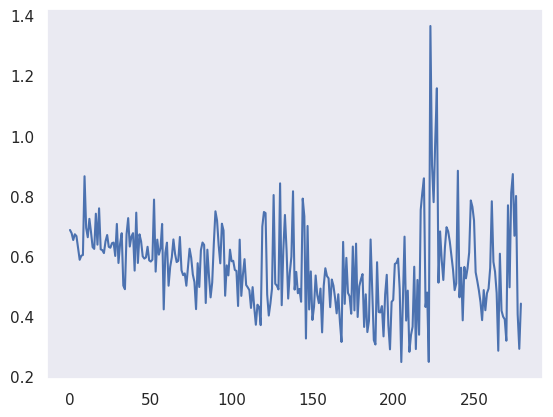

In [22]:
plt.plot(train_losses)

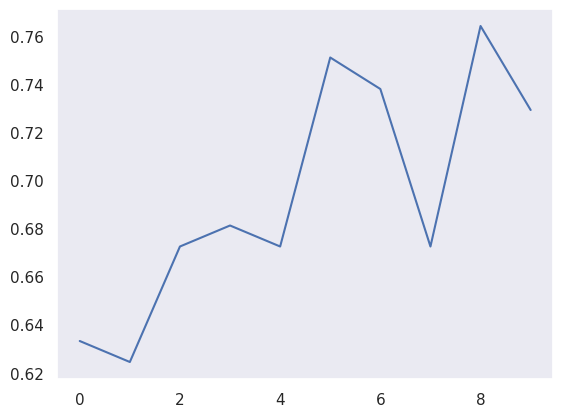

In [23]:
plt.plot(test_accuracy)

In [24]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 168/229 (0.7336)
F1: 0.75
UAP: 0.8418090343475342
WAP: 0.75
UAR: 0.6484504342079163
WAR: 0.75
tensor([[ 24,  55],
        [  1, 144]], device='cuda:0')


In [23]:
# import torchmetrics
# f1score = torchmetrics.F1Score(
#     task='multiclass', num_classes=len(labels)
# ).to(device)
# uap = torchmetrics.Precision(
#     task='multiclass', num_classes=len(labels), average='macro'
# ).to(device)
# wap = torchmetrics.Precision(
#     task='multiclass', num_classes=len(labels), average='micro'
# ).to(device)    
# uar = torchmetrics.Recall(
#     task='multiclass', num_classes=len(labels), average='macro'
# ).to(device)
# war = torchmetrics.Recall(
#     task='multiclass', num_classes=len(labels), average='micro'
# ).to(device)
# confusion_matrix = torchmetrics.ConfusionMatrix(
#     task='multiclass', num_classes=len(labels)
# ).to(device)

# model.eval()
# correct = 0
# for data, target in test_loader:
#     data = data.to(device)
#     target = target.to(device)
#     output = model(data).squeeze()
#     del data
#     gc.collect()
#     torch.cuda.empty_cache()
#     probs = F.softmax(output, dim=-1)
#     pred = probs.argmax(dim=-1)
#     correct += pred.eq(target).sum().item()
#     f1score(pred, target)
#     uap(pred, target)
#     wap(pred, target)
#     uar(pred, target)
#     war(pred, target)
#     confusion_matrix(pred, target)
#     del target
#     gc.collect()
#     torch.cuda.empty_cache()
#     pbar.update(pbar_update)
# print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
# F1 = f1score.compute()
# UAP = uap.compute()
# WAP = wap.compute()
# UAR = uar.compute()
# WAR = war.compute()
# cm = confusion_matrix.compute()
# print(f'F1: {F1}')
# print(f'UAP: {UAP}')
# print(f'WAP: {WAP}')
# print(f'UAR: {UAR}')
# print(f'WAR: {WAR}')
# print(cm)

Correct: 173/229 (0.7555)
F1: 0.7723214030265808
UAP: 0.7896465063095093
WAP: 0.7723214030265808
UAR: 0.7002618908882141
WAR: 0.7723214030265808
tensor([[ 36,  43],
        [  8, 137]], device='cuda:0')


In [24]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0048],
        [0.0102],
        [0.0162],
        [0.0228],
        [0.0302],
        [0.0384],
        [0.0475],
        [0.0576],
        [0.0688],
        [0.0813],
        [0.0951],
        [0.1105],
        [0.1276],
        [0.1465],
        [0.1676],
        [0.1910],
        [0.2170],
        [0.2458],
        [0.2779],
        [0.3135],
        [0.3531],
        [0.3970],
        [0.4458],
        [0.0000],
        [0.0072],
        [0.0150],
        [0.0235],
        [0.0327],
        [0.0426],
        [0.0534],
        [0.0650],
        [0.0776],
        [0.0912],
        [0.1060],
        [0.1219],
        [0.1392],
        [0.1580],
        [0.1782],
        [0.2002],
        [0.2239],
        [0.2496],
        [0.2775],
        [0.3076],
        [0.3402],
        [0.3756],
        [0.4138],
        [0.4552],
        [0.0000],
        [0.0101],
        [0.0208],
        [0.0322],
        [0.0442],
       

In [25]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 7.0674e-16],
        [-6.9697e-16],
        [ 3.8278e-16],
        [-3.8599e-16],
        [ 2.5224e-17],
        [-2.0508e-16],
        [-2.9627e-17],
        [ 3.2845e-18],
        [ 1.3845e-16],
        [ 2.1797e-18],
        [-9.1800e-18],
        [ 6.1198e-19],
        [-8.0780e-16],
        [ 5.1837e-16],
        [-5.7362e-18],
        [-2.3531e-17],
        [ 3.4509e-17],
        [-9.6085e-18],
        [-2.0641e-18],
        [ 9.3732e-19],
        [-1.8673e-18],
        [-8.4099e-19],
        [ 2.1527e-18],
        [ 0.0000e+00],
        [-1.9930e-15],
        [-4.5902e-15],
        [-5.4211e-14],
        [ 1.8749e-16],
        [ 2.5597e-16],
        [ 1.0292e-17],
        [-2.6623e-18],
        [-7.1091e-18],
        [ 3.3704e-18],
        [ 2.0999e-18],
        [-3.7667e-18],
        [ 3.0984e-17],
        [-1.4864e-17],
        [ 5.2912e-18],
        [-1.3087e-18],
        [-2.8428e-18],
        [ 3.4132e-17],
        [-8.2100e-17],
        [ 1

[None, None, None]

In [26]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

Time domain: Filters' shapes vary by frequency bins


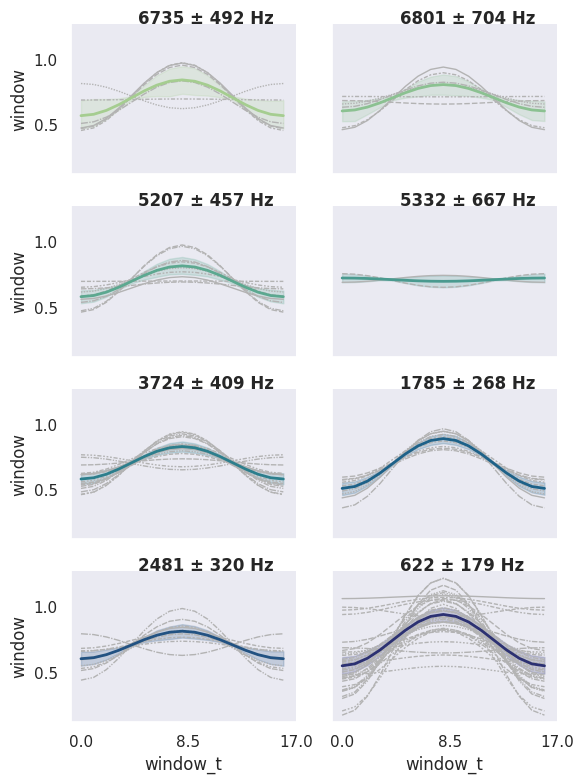

In [27]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


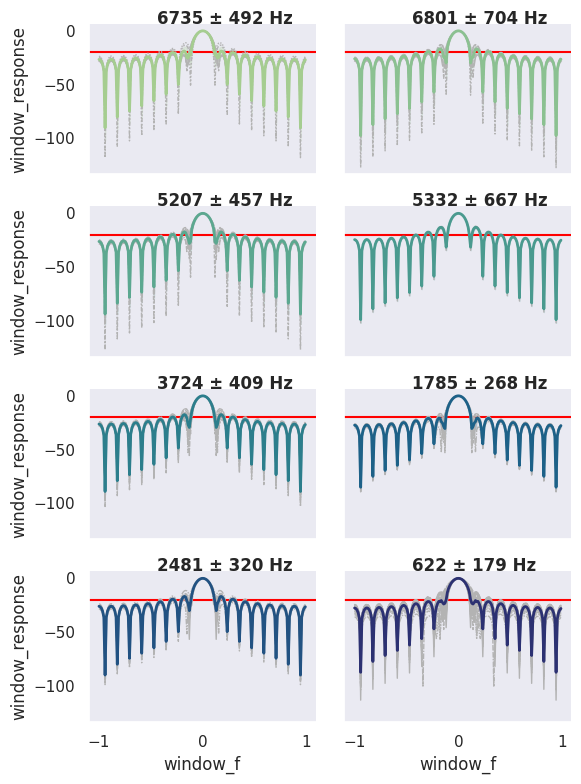

In [28]:
filtviz.visualize_filters(filter_domain='freq')

In [29]:
layer2 = model.fe_blocks.blocks[1].layer
downsample_factor = model.config.fe.stride[0]

In [30]:
[print(p.grad) for p in layer2.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0506e-18, -1.6174e-18,  2.5715e-18,  ...,  4.1395e-18,
          3.9677e-18,  4.0512e-18],
        [ 3.7562e-19,  8.6445e-19, -1.2726e-18,  ..., -1.9046e-18,
         -1.7988e-18, -1.8348e-18],
        ...,
        [ 1.2340e-18, -1.2824e-18, -1.6409e-18,  ..., -3.7576e-18,
         -3.5845e-18, -3.6628e-18],
        [ 5.2808e-17, -6.3453e-18, -3.3719e-17,  ..., -2.6876e-17,
         -2.6913e-17, -2.7903e-17],
        [-1.5790e-18,  9.3807e-19,  2.4459e-18,  ...,  3.1878e-18,
          2.9876e-18,  3.0643e-18]], device='cuda:0')
tensor([[-8.8599e-19,  1.1759e-18,  8.7480e-19,  ...,  1.1408e-18,
          1.0948e-18,  1.1213e-18],
        [-2.0345e-18, -1.1874e-18,  3.1053e-18,  ...,  5.0753e-18,
          4.8628e-18,  4.9668e-18],
        [ 1.0718e-19,  1.9120e-19, -7.4374e-20,  ..., -3.2010e-19,
         -3.0235e-19, -3.0779e-19],
        ...,
        [ 1.3217e-18, -1.3748

[None, None, None]

In [31]:
filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr // downsample_factor
)

Time domain: Filters' shapes vary by frequency bins


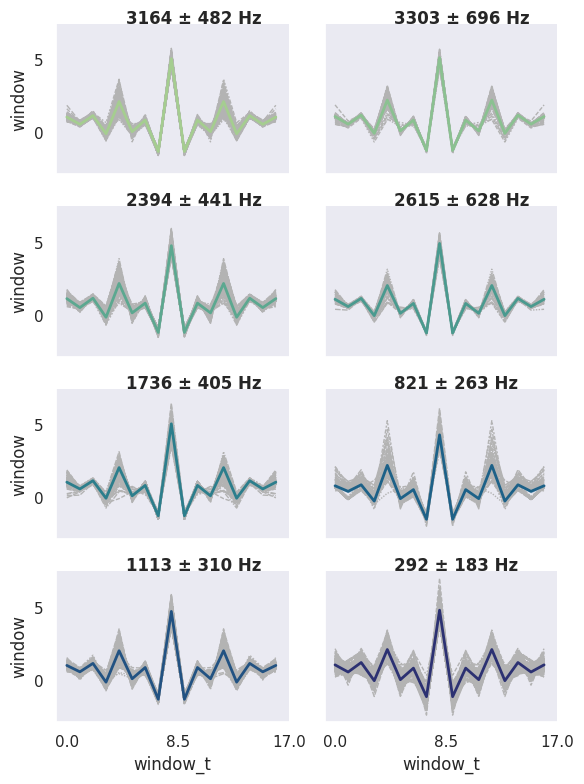

In [32]:
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


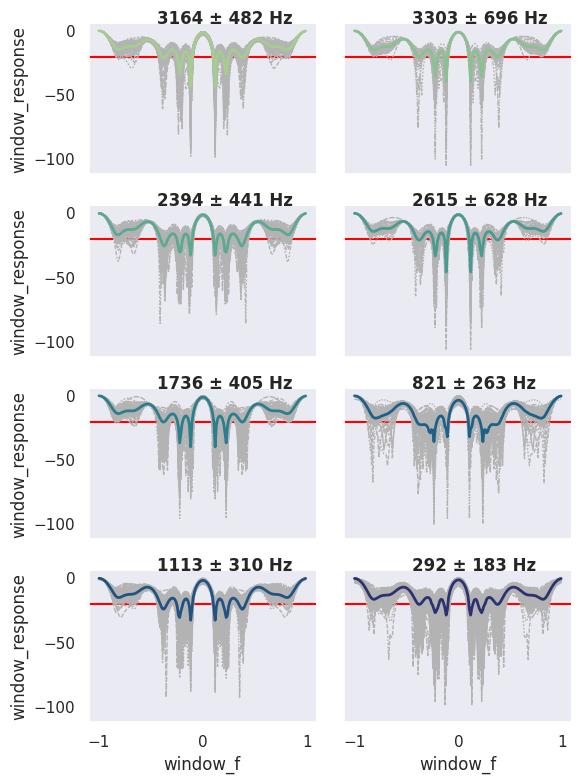

In [33]:
filtviz2.visualize_filters(filter_domain='freq')

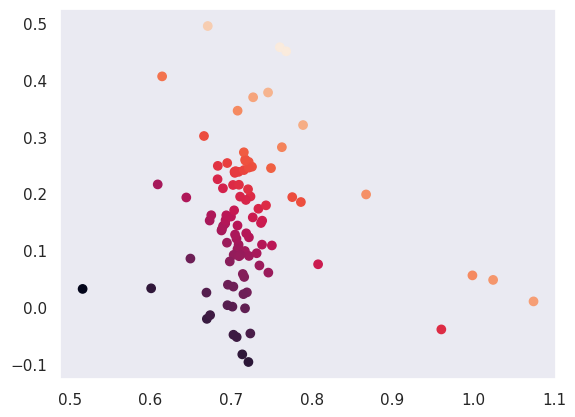

In [34]:
filtviz.visualize_window_params()

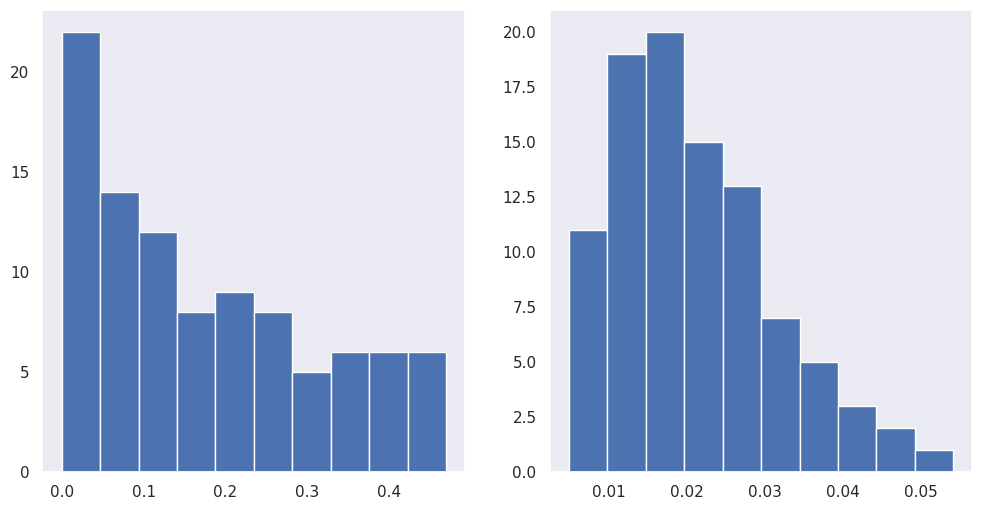

In [35]:
filtviz.visualize_bands()

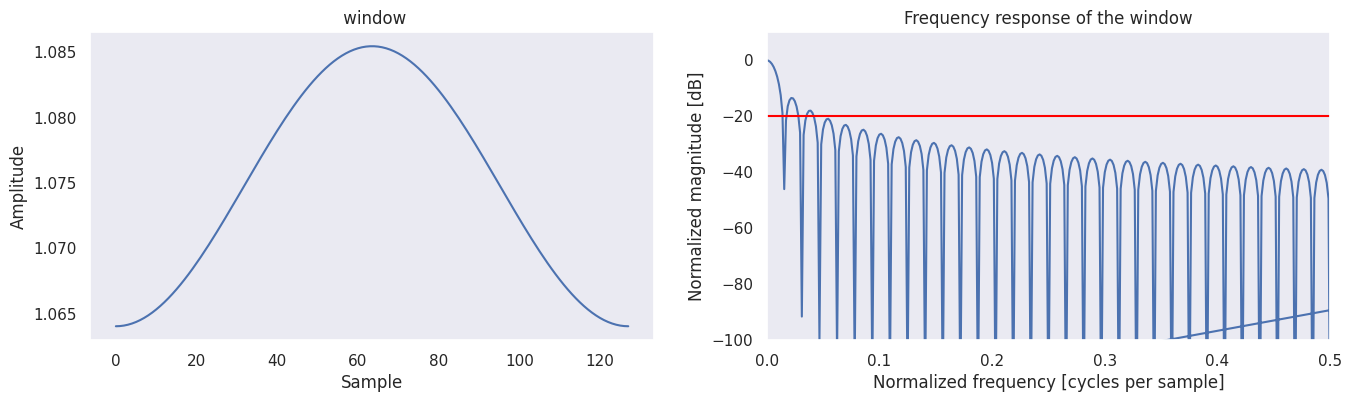

In [36]:
filtviz.visualize_one_window()

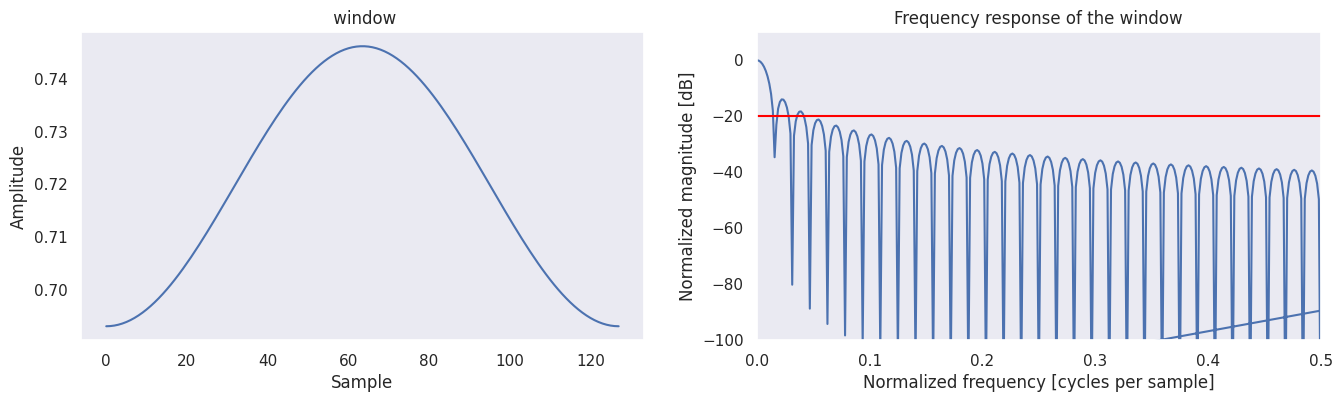

In [37]:
filtviz.visualize_one_window(n_out=20, n_inp=0)

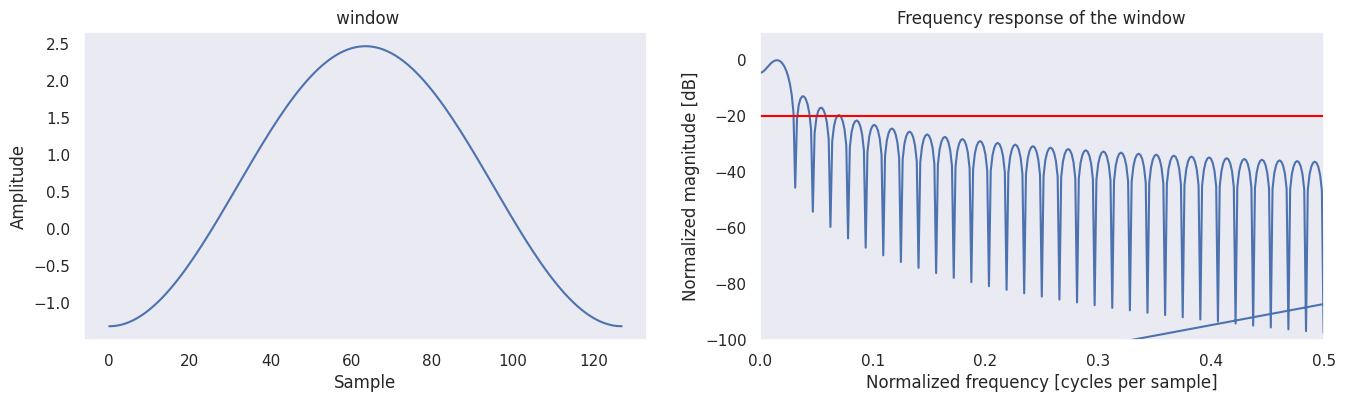

In [54]:
filtviz.visualize_one_window(n_out=30, n_inp=0)

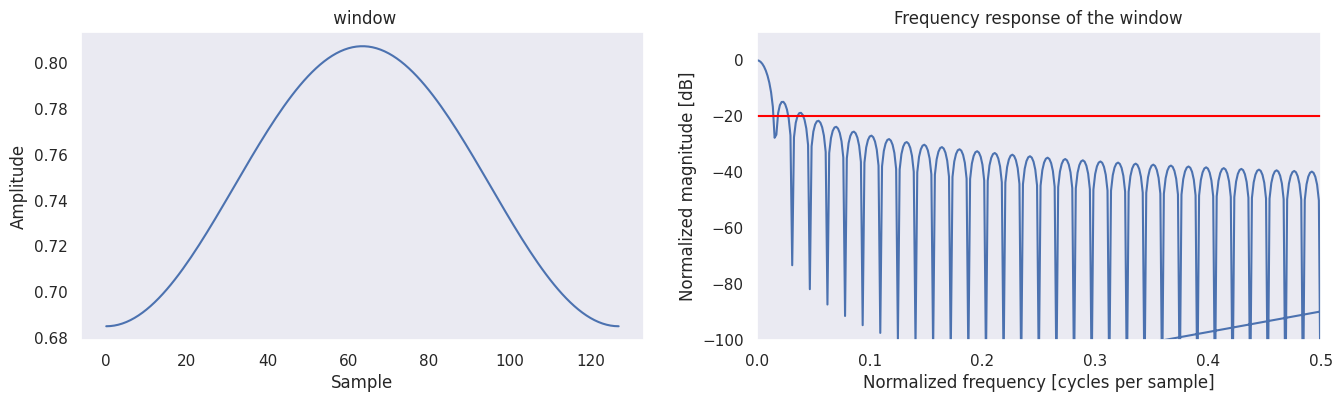

In [38]:
filtviz.visualize_one_window(n_out=60, n_inp=0)

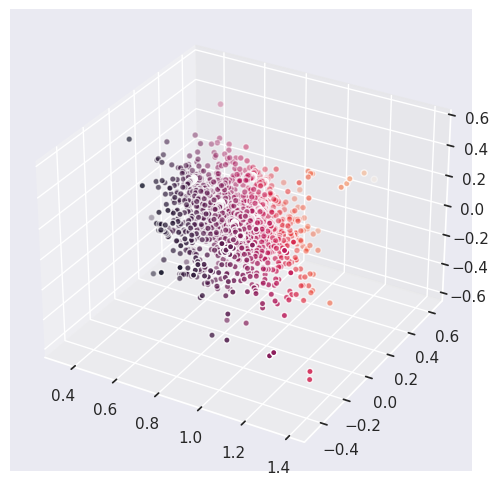

In [39]:
filtviz2.visualize_window_params()

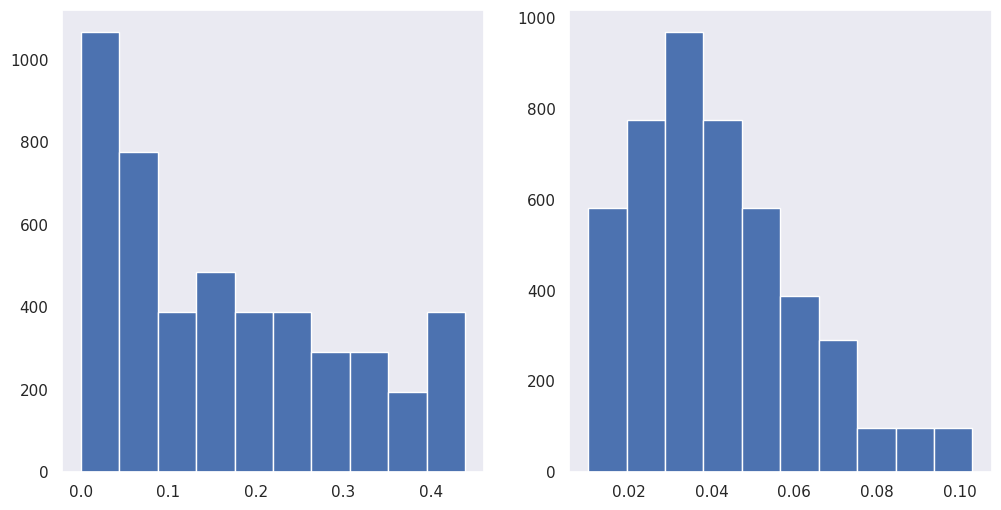

In [40]:
filtviz2.visualize_bands()

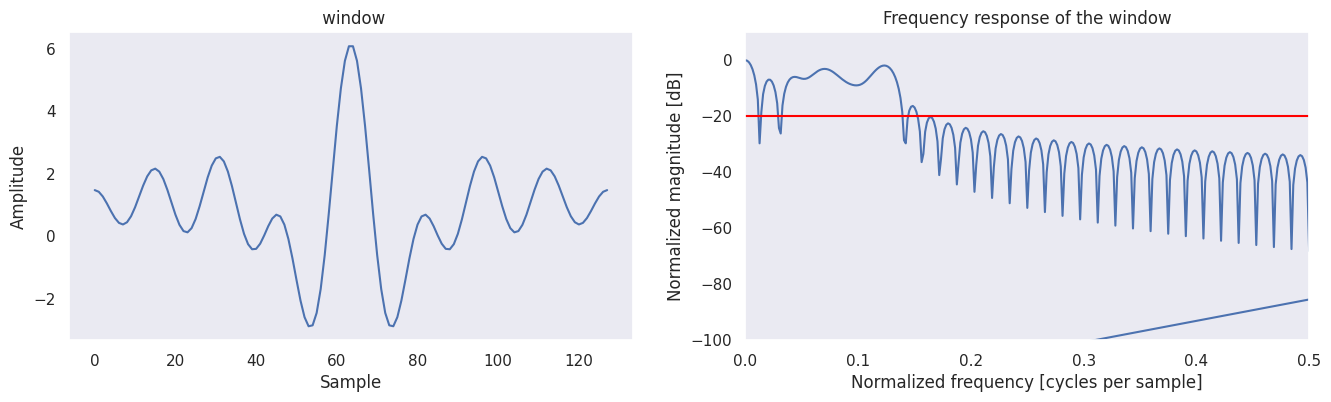

In [41]:
filtviz2.visualize_one_window()

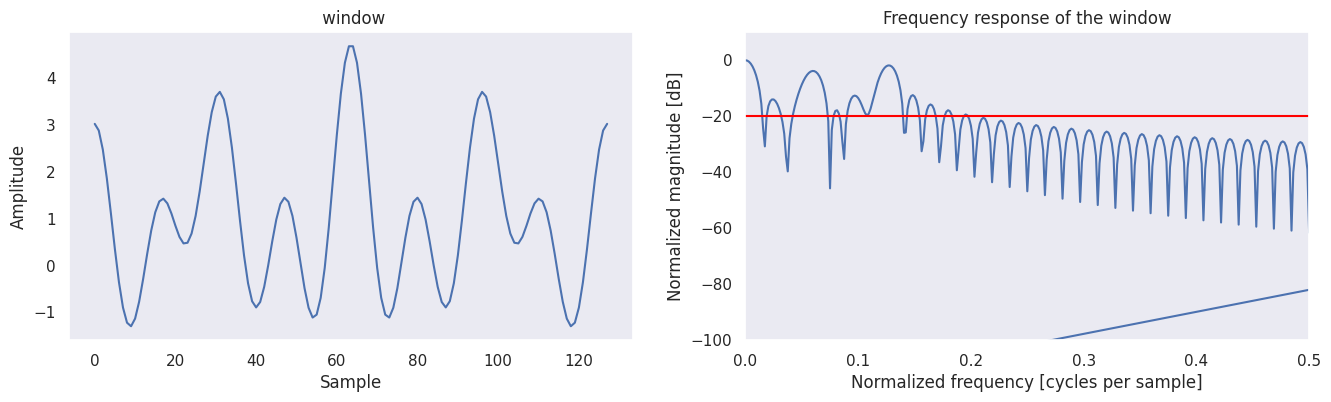

In [51]:
filtviz2.visualize_one_window(n_out=30, n_inp=60)

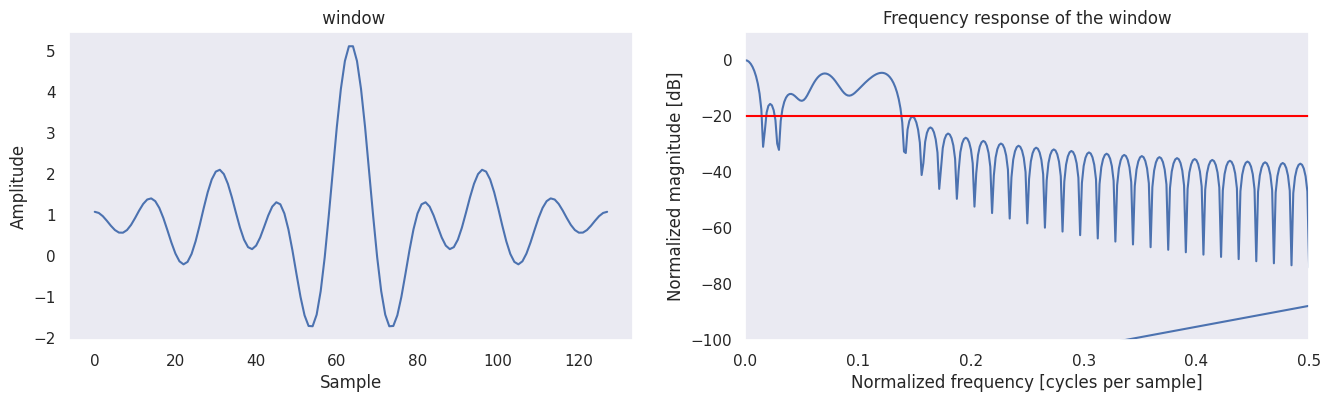

In [42]:
filtviz2.visualize_one_window(n_out=20, n_inp=20)

In [43]:
model_path = '../heartsound_m13_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [25]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2+n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02857142857142857/50 [00:00<09:39, 11.59s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.352536


  2%|█▌                                                                           | 1.0000000000000002/50 [00:10<06:03,  7.42s/it]


Test Epoch: 11	Accuracy: 180/229 (79%)



  2%|█▌                                                                           | 1.0285714285714287/50 [00:10<06:50,  8.38s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.535836


  4%|███                                                                          | 1.9999999999999967/50 [00:20<06:11,  7.75s/it]


Test Epoch: 12	Accuracy: 178/229 (78%)



  4%|███▏                                                                          | 2.057142857142854/50 [00:20<06:23,  7.99s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.415700


  6%|████▌                                                                        | 2.9999999999999933/50 [00:29<05:45,  7.35s/it]


Test Epoch: 13	Accuracy: 178/229 (78%)



  6%|████▋                                                                         | 3.028571428571422/50 [00:30<06:33,  8.38s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.353963


  8%|██████▎                                                                        | 3.99999999999999/50 [00:39<05:34,  7.27s/it]


Test Epoch: 14	Accuracy: 181/229 (79%)



  8%|██████▎                                                                       | 4.028571428571419/50 [00:39<06:22,  8.31s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.353195


 10%|███████▊                                                                      | 4.999999999999987/50 [00:49<05:29,  7.31s/it]


Test Epoch: 15	Accuracy: 186/229 (81%)



 10%|███████▉                                                                      | 5.057142857142844/50 [00:49<05:51,  7.81s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.344018


 12%|█████████▎                                                                    | 5.999999999999983/50 [00:59<05:19,  7.27s/it]


Test Epoch: 16	Accuracy: 185/229 (81%)



 12%|█████████▌                                                                     | 6.05714285714284/50 [00:59<05:49,  7.96s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.174296


 14%|███████████                                                                    | 6.99999999999998/50 [01:09<05:10,  7.23s/it]


Test Epoch: 17	Accuracy: 185/229 (81%)



 14%|██████████▉                                                                   | 7.028571428571408/50 [01:09<05:56,  8.30s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.502607


 16%|████████████▍                                                                 | 7.999999999999976/50 [01:19<06:48,  9.73s/it]


Test Epoch: 18	Accuracy: 180/229 (79%)



 16%|████████████▌                                                                 | 8.057142857142834/50 [01:19<06:16,  8.98s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.219215


 18%|██████████████                                                                | 8.999999999999973/50 [01:29<05:00,  7.33s/it]


Test Epoch: 19	Accuracy: 179/229 (78%)



 18%|██████████████▎                                                                | 9.05714285714283/50 [01:29<05:23,  7.91s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.374352


 20%|███████████████▊                                                               | 9.99999999999997/50 [01:38<04:52,  7.32s/it]


Test Epoch: 20	Accuracy: 180/229 (79%)



 20%|███████████████▍                                                             | 10.057142857142827/50 [01:39<05:18,  7.97s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.367743


 22%|████████████████▉                                                            | 10.999999999999966/50 [01:48<05:02,  7.77s/it]


Test Epoch: 21	Accuracy: 187/229 (82%)



 22%|█████████████████                                                            | 11.057142857142823/50 [01:49<05:12,  8.02s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.483354


 24%|██████████████████▍                                                          | 11.999999999999963/50 [01:58<04:42,  7.42s/it]


Test Epoch: 22	Accuracy: 178/229 (78%)



 24%|██████████████████▊                                                           | 12.05714285714282/50 [01:59<05:02,  7.97s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.433818


 26%|████████████████████▎                                                         | 12.99999999999996/50 [02:08<04:26,  7.20s/it]


Test Epoch: 23	Accuracy: 190/229 (83%)



 26%|████████████████████                                                         | 13.028571428571388/50 [02:09<05:05,  8.26s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.352566


 28%|█████████████████████▌                                                       | 13.999999999999956/50 [02:18<04:23,  7.33s/it]


Test Epoch: 24	Accuracy: 183/229 (80%)



 28%|█████████████████████▋                                                       | 14.057142857142813/50 [02:19<04:44,  7.92s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.428763


 30%|███████████████████████                                                      | 14.999999999999952/50 [02:28<04:15,  7.29s/it]


Test Epoch: 25	Accuracy: 186/229 (81%)



 30%|███████████████████████▏                                                     | 15.057142857142809/50 [02:29<04:36,  7.92s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.155978


 32%|████████████████████████▋                                                    | 15.999999999999948/50 [02:38<04:10,  7.37s/it]


Test Epoch: 26	Accuracy: 184/229 (80%)



 32%|█████████████████████████                                                     | 16.02857142857138/50 [02:38<04:45,  8.39s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.274071


 34%|██████████████████████████▏                                                  | 16.999999999999947/50 [02:48<04:01,  7.32s/it]


Test Epoch: 27	Accuracy: 173/229 (76%)



 34%|██████████████████████████▎                                                  | 17.057142857142804/50 [02:49<04:24,  8.04s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.404204


 36%|███████████████████████████▋                                                 | 17.999999999999943/50 [02:58<03:53,  7.29s/it]


Test Epoch: 28	Accuracy: 186/229 (81%)



 36%|████████████████████████████▌                                                  | 18.0571428571428/50 [02:59<04:11,  7.87s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.266728


 38%|█████████████████████████████▋                                                | 18.99999999999994/50 [03:08<03:50,  7.44s/it]


Test Epoch: 29	Accuracy: 191/229 (83%)



 38%|█████████████████████████████▎                                               | 19.028571428571368/50 [03:08<04:21,  8.45s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.243432


 40%|██████████████████████████████▊                                              | 19.999999999999936/50 [03:18<03:37,  7.25s/it]


Test Epoch: 30	Accuracy: 185/229 (81%)



 40%|██████████████████████████████▉                                              | 20.057142857142793/50 [03:18<03:57,  7.92s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.443213


 42%|████████████████████████████████▎                                            | 20.999999999999932/50 [03:28<03:31,  7.30s/it]


Test Epoch: 31	Accuracy: 189/229 (83%)



 42%|████████████████████████████████▊                                             | 21.05714285714279/50 [03:28<03:48,  7.91s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.146045


 44%|██████████████████████████████████▎                                           | 21.99999999999993/50 [03:38<03:24,  7.30s/it]


Test Epoch: 32	Accuracy: 192/229 (84%)



 44%|█████████████████████████████████▉                                           | 22.057142857142786/50 [03:38<03:38,  7.84s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.353782


 46%|███████████████████████████████████▍                                         | 22.999999999999925/50 [03:48<03:20,  7.43s/it]


Test Epoch: 33	Accuracy: 185/229 (81%)



 46%|███████████████████████████████████▌                                         | 23.057142857142782/50 [03:48<03:34,  7.95s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.363080


 48%|████████████████████████████████████▉                                        | 23.999999999999922/50 [03:58<03:10,  7.33s/it]


Test Epoch: 34	Accuracy: 177/229 (77%)



 48%|█████████████████████████████████████▌                                        | 24.05714285714278/50 [03:58<03:25,  7.91s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.362927


 50%|██████████████████████████████████████▉                                       | 24.99999999999992/50 [04:08<03:04,  7.37s/it]


Test Epoch: 35	Accuracy: 194/229 (85%)



 50%|██████████████████████████████████████▌                                      | 25.057142857142775/50 [04:08<03:19,  7.98s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.221497


 52%|████████████████████████████████████████                                     | 25.999999999999915/50 [04:18<02:57,  7.40s/it]


Test Epoch: 36	Accuracy: 187/229 (82%)



 52%|████████████████████████████████████████▋                                     | 26.05714285714277/50 [04:18<04:05, 10.27s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.332917


 54%|██████████████████████████████████████████                                    | 26.99999999999991/50 [04:28<02:47,  7.28s/it]


Test Epoch: 37	Accuracy: 177/229 (77%)



 54%|█████████████████████████████████████████▋                                   | 27.057142857142768/50 [04:28<02:56,  7.70s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.629671


 56%|███████████████████████████████████████████                                  | 27.999999999999908/50 [04:38<02:42,  7.36s/it]


Test Epoch: 38	Accuracy: 194/229 (85%)



 56%|███████████████████████████████████████████▏                                 | 28.057142857142765/50 [04:38<02:55,  7.98s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.091219


 58%|████████████████████████████████████████████▋                                | 28.999999999999904/50 [04:48<02:32,  7.24s/it]


Test Epoch: 39	Accuracy: 162/229 (71%)



 58%|█████████████████████████████████████████████▎                                | 29.05714285714276/50 [04:48<02:42,  7.75s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.377779


 60%|███████████████████████████████████████████████▍                               | 29.9999999999999/50 [04:58<02:26,  7.31s/it]


Test Epoch: 40	Accuracy: 198/229 (86%)



 60%|██████████████████████████████████████████████▎                              | 30.057142857142757/50 [04:58<02:36,  7.84s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.202280


 62%|███████████████████████████████████████████████▋                             | 30.999999999999897/50 [05:08<02:22,  7.49s/it]


Test Epoch: 41	Accuracy: 191/229 (83%)



 62%|███████████████████████████████████████████████▊                             | 31.028571428571325/50 [05:08<02:39,  8.40s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.261560


 64%|█████████████████████████████████████████████████▎                           | 31.999999999999893/50 [05:18<02:17,  7.65s/it]


Test Epoch: 42	Accuracy: 181/229 (79%)



 64%|█████████████████████████████████████████████████▎                           | 32.028571428571325/50 [05:18<02:36,  8.71s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.284215


 66%|██████████████████████████████████████████████████▊                          | 33.000000000000014/50 [05:28<02:08,  7.56s/it]


Test Epoch: 43	Accuracy: 188/229 (82%)



 66%|███████████████████████████████████████████████████▌                          | 33.05714285714288/50 [05:29<02:14,  7.95s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.335833


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000135/50 [05:38<01:55,  7.24s/it]


Test Epoch: 44	Accuracy: 162/229 (71%)



 68%|█████████████████████████████████████████████████████                         | 34.02857142857157/50 [05:38<02:13,  8.36s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.657270


 70%|█████████████████████████████████████████████████████▉                       | 35.000000000000256/50 [05:48<01:53,  7.59s/it]


Test Epoch: 45	Accuracy: 180/229 (79%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02857142857169/50 [05:48<02:08,  8.60s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.220632


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000038/50 [05:58<01:41,  7.26s/it]


Test Epoch: 46	Accuracy: 186/229 (81%)



 72%|████████████████████████████████████████████████████████▏                     | 36.02857142857181/50 [05:58<01:57,  8.38s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.357414


 74%|██████████████████████████████████████████████████████████▍                    | 37.0000000000005/50 [06:08<01:36,  7.45s/it]


Test Epoch: 47	Accuracy: 197/229 (86%)



 74%|█████████████████████████████████████████████████████████▊                    | 37.02857142857193/50 [06:08<01:50,  8.54s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.108381


 76%|███████████████████████████████████████████████████████████▎                  | 38.00000000000062/50 [06:18<01:28,  7.39s/it]


Test Epoch: 48	Accuracy: 201/229 (88%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02857142857205/50 [06:18<01:41,  8.46s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.396165


 78%|████████████████████████████████████████████████████████████▊                 | 39.00000000000074/50 [06:28<01:23,  7.55s/it]


Test Epoch: 49	Accuracy: 190/229 (83%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02857142857217/50 [06:28<01:34,  8.57s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.445700


 80%|██████████████████████████████████████████████████████████████▍               | 40.00000000000086/50 [06:38<01:14,  7.40s/it]


Test Epoch: 50	Accuracy: 192/229 (84%)



 80%|██████████████████████████████████████████████████████████████▍               | 40.02857142857229/50 [06:38<01:25,  8.53s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.350638


 82%|███████████████████████████████████████████████████████████████▉              | 41.00000000000098/50 [06:48<01:06,  7.34s/it]


Test Epoch: 51	Accuracy: 185/229 (81%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.057142857143845/50 [06:49<01:11,  7.95s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.252360


 84%|██████████████████████████████████████████████████████████████████▎            | 42.0000000000011/50 [06:58<00:58,  7.33s/it]


Test Epoch: 52	Accuracy: 189/229 (83%)



 84%|████████████████████████████████████████████████████████████████▊            | 42.057142857143965/50 [06:59<01:03,  7.97s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.341981


 86%|███████████████████████████████████████████████████████████████████           | 43.00000000000122/50 [07:08<00:51,  7.36s/it]


Test Epoch: 53	Accuracy: 181/229 (79%)



 86%|██████████████████████████████████████████████████████████████████▎          | 43.028571428572654/50 [07:08<00:58,  8.44s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.556644


 88%|████████████████████████████████████████████████████████████████████▋         | 44.00000000000134/50 [07:18<00:44,  7.50s/it]


Test Epoch: 54	Accuracy: 194/229 (85%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.05714285714421/50 [07:19<00:47,  8.03s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.340886


 90%|█████████████████████████████████████████████████████████████████████▎       | 45.000000000001464/50 [07:28<00:37,  7.43s/it]


Test Epoch: 55	Accuracy: 191/229 (83%)



 90%|██████████████████████████████████████████████████████████████████████▎       | 45.05714285714433/50 [07:29<00:39,  8.01s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.404029


 92%|██████████████████████████████████████████████████████████████████████▊      | 46.000000000001585/50 [07:38<00:32,  8.05s/it]


Test Epoch: 56	Accuracy: 155/229 (68%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.05714285714445/50 [07:39<00:32,  8.19s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.567095


 94%|████████████████████████████████████████████████████████████████████████▍    | 47.000000000001705/50 [07:48<00:23,  7.69s/it]


Test Epoch: 57	Accuracy: 194/229 (85%)



 94%|█████████████████████████████████████████████████████████████████████████▍    | 47.05714285714457/50 [07:49<00:24,  8.26s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.169512


 96%|█████████████████████████████████████████████████████████████████████████▉   | 48.000000000001826/50 [07:58<00:15,  7.57s/it]


Test Epoch: 58	Accuracy: 183/229 (80%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02857142857326/50 [07:59<00:17,  8.73s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.504651


 98%|████████████████████████████████████████████████████████████████████████████▍ | 49.00000000000195/50 [08:09<00:07,  7.60s/it]


Test Epoch: 59	Accuracy: 187/229 (82%)



 98%|████████████████████████████████████████████████████████████████████████████▌ | 49.05714285714481/50 [08:09<00:07,  8.04s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.214915


100%|████████████████████████████████████████████████████████████████████████████▉| 49.971428571430636/50 [08:19<00:00,  7.84s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████████████| 50.00000000000207/50 [08:19<00:00,  9.99s/it]


Test Epoch: 60	Accuracy: 190/229 (83%)



In [26]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 190/229 (0.8297)
F1: 0.8482142686843872
UAP: 0.836241602897644
WAP: 0.8482142686843872
UAR: 0.8280227184295654
WAR: 0.8482142686843872
tensor([[ 60,  19],
        [ 15, 130]], device='cuda:0')


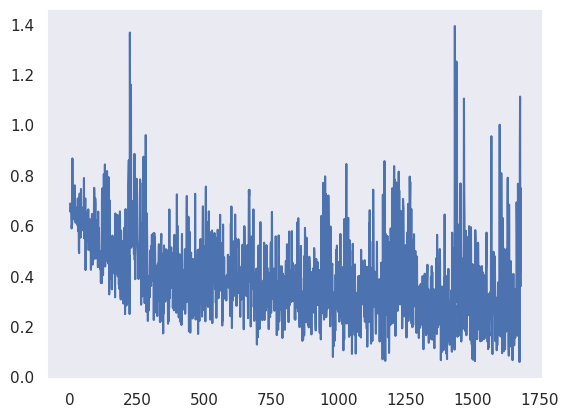

In [27]:
plt.plot(train_losses)

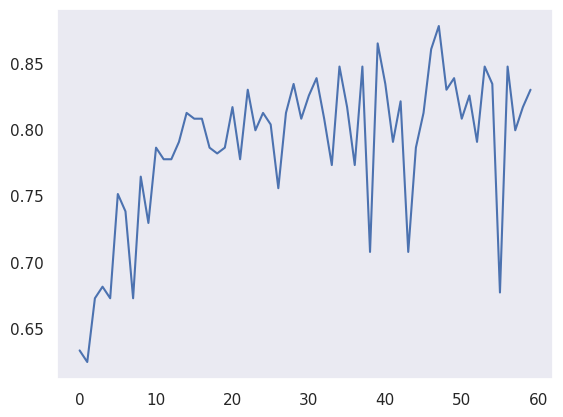

In [28]:
plt.plot(test_accuracy)

In [29]:
model_path = '../heartsound_m13_2_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [30]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 60
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3 + n_epoch2+n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02857142857142857/60 [00:00<11:30, 11.51s/it]

Train Epoch: 61 [0/913 (0%)]	Loss: 0.159844


  2%|█▎                                                                           | 1.0000000000000002/60 [00:10<07:25,  7.56s/it]


Test Epoch: 61	Accuracy: 199/229 (87%)



  2%|█▎                                                                           | 1.0571428571428572/60 [00:10<07:52,  8.02s/it]

Train Epoch: 62 [0/913 (0%)]	Loss: 0.148078


  3%|██▌                                                                          | 1.9999999999999967/60 [00:19<07:09,  7.41s/it]


Test Epoch: 62	Accuracy: 197/229 (86%)



  3%|██▋                                                                           | 2.057142857142854/60 [00:20<07:30,  7.78s/it]

Train Epoch: 63 [0/913 (0%)]	Loss: 0.255043


  5%|███▊                                                                         | 2.9999999999999933/60 [00:29<06:56,  7.30s/it]


Test Epoch: 63	Accuracy: 199/229 (87%)



  5%|███▉                                                                          | 3.028571428571422/60 [00:30<07:58,  8.39s/it]

Train Epoch: 64 [0/913 (0%)]	Loss: 0.088064


  7%|█████▎                                                                         | 3.99999999999999/60 [00:39<06:55,  7.42s/it]


Test Epoch: 64	Accuracy: 203/229 (89%)



  7%|█████▎                                                                        | 4.057142857142847/60 [00:40<07:23,  7.92s/it]

Train Epoch: 65 [0/913 (0%)]	Loss: 0.041166


  8%|██████▍                                                                       | 4.999999999999987/60 [00:49<06:41,  7.30s/it]


Test Epoch: 65	Accuracy: 192/229 (84%)



  8%|██████▌                                                                       | 5.028571428571415/60 [00:49<07:42,  8.42s/it]

Train Epoch: 66 [0/913 (0%)]	Loss: 0.225695


 10%|███████▊                                                                      | 5.999999999999983/60 [00:59<06:30,  7.23s/it]


Test Epoch: 66	Accuracy: 200/229 (87%)



 10%|███████▊                                                                      | 6.028571428571412/60 [00:59<07:31,  8.37s/it]

Train Epoch: 67 [0/913 (0%)]	Loss: 0.308507


 12%|█████████▏                                                                     | 6.99999999999998/60 [01:09<06:25,  7.28s/it]


Test Epoch: 67	Accuracy: 197/229 (86%)



 12%|█████████                                                                    | 7.0571428571428365/60 [01:09<06:52,  7.80s/it]

Train Epoch: 68 [0/913 (0%)]	Loss: 0.194126


 13%|██████████▍                                                                   | 7.999999999999976/60 [01:19<06:21,  7.34s/it]


Test Epoch: 68	Accuracy: 201/229 (88%)



 13%|██████████▍                                                                   | 8.057142857142834/60 [01:19<06:50,  7.89s/it]

Train Epoch: 69 [0/913 (0%)]	Loss: 0.289884


 15%|███████████▋                                                                  | 8.999999999999973/60 [01:29<06:15,  7.37s/it]


Test Epoch: 69	Accuracy: 195/229 (85%)



 15%|███████████▋                                                                  | 9.028571428571402/60 [01:29<07:08,  8.40s/it]

Train Epoch: 70 [0/913 (0%)]	Loss: 0.184432


 17%|█████████████▏                                                                 | 9.99999999999997/60 [01:39<06:05,  7.30s/it]


Test Epoch: 70	Accuracy: 199/229 (87%)



 17%|████████████▊                                                                | 10.028571428571398/60 [01:39<07:00,  8.41s/it]

Train Epoch: 71 [0/913 (0%)]	Loss: 0.128667


 18%|██████████████                                                               | 10.999999999999966/60 [01:49<06:17,  7.70s/it]


Test Epoch: 71	Accuracy: 203/229 (89%)



 18%|██████████████▏                                                              | 11.057142857142823/60 [01:49<06:29,  7.96s/it]

Train Epoch: 72 [0/913 (0%)]	Loss: 0.158235


 20%|███████████████▍                                                             | 11.999999999999963/60 [01:59<06:30,  8.13s/it]


Test Epoch: 72	Accuracy: 195/229 (85%)



 20%|███████████████▋                                                              | 12.05714285714282/60 [01:59<06:39,  8.34s/it]

Train Epoch: 73 [0/913 (0%)]	Loss: 0.173344


 22%|████████████████▉                                                             | 12.99999999999996/60 [02:09<05:45,  7.34s/it]


Test Epoch: 73	Accuracy: 199/229 (87%)



 22%|████████████████▊                                                            | 13.057142857142816/60 [02:09<06:08,  7.86s/it]

Train Epoch: 74 [0/913 (0%)]	Loss: 0.084743


 23%|█████████████████▉                                                           | 13.999999999999956/60 [02:19<05:34,  7.27s/it]


Test Epoch: 74	Accuracy: 203/229 (89%)



 23%|██████████████████                                                           | 14.057142857142813/60 [02:19<06:04,  7.93s/it]

Train Epoch: 75 [0/913 (0%)]	Loss: 0.460149


 25%|███████████████████▏                                                         | 14.999999999999952/60 [02:29<05:30,  7.34s/it]


Test Epoch: 75	Accuracy: 204/229 (89%)



 25%|███████████████████▎                                                         | 15.057142857142809/60 [02:29<05:55,  7.90s/it]

Train Epoch: 76 [0/913 (0%)]	Loss: 0.176665


 27%|████████████████████▌                                                        | 15.999999999999948/60 [02:38<05:38,  7.70s/it]


Test Epoch: 76	Accuracy: 185/229 (81%)



 27%|████████████████████▌                                                        | 16.057142857142807/60 [02:39<05:54,  8.06s/it]

Train Epoch: 77 [0/913 (0%)]	Loss: 0.193335


 28%|█████████████████████▊                                                       | 16.999999999999947/60 [02:49<05:21,  7.48s/it]


Test Epoch: 77	Accuracy: 202/229 (88%)



 28%|█████████████████████▉                                                       | 17.057142857142804/60 [02:49<06:09,  8.60s/it]

Train Epoch: 78 [0/913 (0%)]	Loss: 0.197502


 30%|███████████████████████                                                      | 17.999999999999943/60 [02:59<05:25,  7.75s/it]


Test Epoch: 78	Accuracy: 197/229 (86%)



 30%|███████████████████████▊                                                       | 18.0571428571428/60 [03:00<05:36,  8.03s/it]

Train Epoch: 79 [0/913 (0%)]	Loss: 0.029251


 32%|████████████████████████▋                                                     | 18.99999999999994/60 [03:09<05:06,  7.48s/it]


Test Epoch: 79	Accuracy: 199/229 (87%)



 32%|████████████████████████▍                                                    | 19.057142857142797/60 [03:10<05:24,  7.93s/it]

Train Epoch: 80 [0/913 (0%)]	Loss: 0.189822


 33%|█████████████████████████▋                                                   | 19.999999999999936/60 [03:19<04:55,  7.39s/it]


Test Epoch: 80	Accuracy: 203/229 (89%)



 33%|█████████████████████████▋                                                   | 20.028571428571365/60 [03:19<05:38,  8.47s/it]

Train Epoch: 81 [0/913 (0%)]	Loss: 0.075180


 35%|██████████████████████████▉                                                  | 20.999999999999932/60 [03:29<04:52,  7.51s/it]


Test Epoch: 81	Accuracy: 200/229 (87%)



 35%|███████████████████████████▎                                                  | 21.05714285714279/60 [03:30<05:13,  8.04s/it]

Train Epoch: 82 [0/913 (0%)]	Loss: 0.117333


 37%|████████████████████████████▌                                                 | 21.99999999999993/60 [03:39<04:39,  7.37s/it]


Test Epoch: 82	Accuracy: 197/229 (86%)



 37%|████████████████████████████▎                                                | 22.057142857142786/60 [03:40<05:02,  7.96s/it]

Train Epoch: 83 [0/913 (0%)]	Loss: 0.031564


 38%|█████████████████████████████▌                                               | 22.999999999999925/60 [03:49<04:35,  7.45s/it]


Test Epoch: 83	Accuracy: 203/229 (89%)



 38%|█████████████████████████████▌                                               | 23.028571428571354/60 [03:50<05:15,  8.54s/it]

Train Epoch: 84 [0/913 (0%)]	Loss: 0.153965


 40%|██████████████████████████████▊                                              | 23.999999999999922/60 [03:59<04:26,  7.41s/it]


Test Epoch: 84	Accuracy: 199/229 (87%)



 40%|███████████████████████████████▎                                              | 24.05714285714278/60 [04:00<04:49,  8.06s/it]

Train Epoch: 85 [0/913 (0%)]	Loss: 0.256682


 42%|████████████████████████████████▍                                             | 24.99999999999992/60 [04:09<04:37,  7.93s/it]


Test Epoch: 85	Accuracy: 204/229 (89%)



 42%|████████████████████████████████▏                                            | 25.057142857142775/60 [04:10<04:44,  8.14s/it]

Train Epoch: 86 [0/913 (0%)]	Loss: 0.141323


 43%|█████████████████████████████████▎                                           | 25.999999999999915/60 [04:19<04:14,  7.49s/it]


Test Epoch: 86	Accuracy: 201/229 (88%)



 43%|█████████████████████████████████▍                                           | 26.028571428571343/60 [04:20<04:50,  8.56s/it]

Train Epoch: 87 [0/913 (0%)]	Loss: 0.216512


 45%|███████████████████████████████████                                           | 26.99999999999991/60 [04:29<04:02,  7.35s/it]


Test Epoch: 87	Accuracy: 205/229 (90%)



 45%|██████████████████████████████████▋                                          | 27.057142857142768/60 [04:30<04:21,  7.93s/it]

Train Epoch: 88 [0/913 (0%)]	Loss: 0.036628


 47%|███████████████████████████████████▉                                         | 27.999999999999908/60 [04:39<03:55,  7.35s/it]


Test Epoch: 88	Accuracy: 205/229 (90%)



 47%|████████████████████████████████████                                         | 28.057142857142765/60 [04:40<04:18,  8.09s/it]

Train Epoch: 89 [0/913 (0%)]	Loss: 0.118143


 48%|█████████████████████████████████████▏                                       | 28.999999999999904/60 [04:49<03:56,  7.64s/it]


Test Epoch: 89	Accuracy: 194/229 (85%)



 48%|█████████████████████████████████████▊                                        | 29.05714285714276/60 [04:50<04:08,  8.04s/it]

Train Epoch: 90 [0/913 (0%)]	Loss: 0.171680


 50%|███████████████████████████████████████▍                                       | 29.9999999999999/60 [04:59<03:45,  7.51s/it]


Test Epoch: 90	Accuracy: 204/229 (89%)



 50%|██████████████████████████████████████▌                                      | 30.057142857142757/60 [05:00<03:57,  7.94s/it]

Train Epoch: 91 [0/913 (0%)]	Loss: 0.065932


 52%|███████████████████████████████████████▊                                     | 30.999999999999897/60 [05:09<03:34,  7.38s/it]


Test Epoch: 91	Accuracy: 204/229 (89%)



 52%|███████████████████████████████████████▊                                     | 31.028571428571325/60 [05:10<04:06,  8.49s/it]

Train Epoch: 92 [0/913 (0%)]	Loss: 0.061686


 53%|█████████████████████████████████████████                                    | 31.999999999999893/60 [05:19<03:27,  7.41s/it]


Test Epoch: 92	Accuracy: 198/229 (86%)



 53%|█████████████████████████████████████████▋                                    | 32.05714285714276/60 [05:20<03:42,  7.96s/it]

Train Epoch: 93 [0/913 (0%)]	Loss: 0.324487


 55%|██████████████████████████████████████████▎                                  | 33.000000000000014/60 [05:29<03:24,  7.58s/it]


Test Epoch: 93	Accuracy: 202/229 (88%)



 55%|██████████████████████████████████████████▉                                   | 33.05714285714288/60 [05:30<03:46,  8.39s/it]

Train Epoch: 94 [0/913 (0%)]	Loss: 0.099143


 57%|███████████████████████████████████████████▋                                 | 34.000000000000135/60 [05:39<03:11,  7.36s/it]


Test Epoch: 94	Accuracy: 195/229 (85%)



 57%|█████████████████████████████████████████████▍                                  | 34.057142857143/60 [05:40<03:24,  7.88s/it]

Train Epoch: 95 [0/913 (0%)]	Loss: 0.106270


 58%|████████████████████████████████████████████▉                                | 35.000000000000256/60 [05:49<03:06,  7.45s/it]


Test Epoch: 95	Accuracy: 189/229 (83%)



 58%|█████████████████████████████████████████████▌                                | 35.05714285714312/60 [05:50<03:21,  8.06s/it]

Train Epoch: 96 [0/913 (0%)]	Loss: 0.271381


 60%|██████████████████████████████████████████████▊                               | 36.00000000000038/60 [05:59<02:58,  7.44s/it]


Test Epoch: 96	Accuracy: 187/229 (82%)



 60%|██████████████████████████████████████████████▊                               | 36.02857142857181/60 [05:59<03:23,  8.50s/it]

Train Epoch: 97 [0/913 (0%)]	Loss: 0.315899


 62%|████████████████████████████████████████████████▋                              | 37.0000000000005/60 [06:09<02:50,  7.40s/it]


Test Epoch: 97	Accuracy: 177/229 (77%)



 62%|████████████████████████████████████████████████▏                             | 37.05714285714336/60 [06:10<03:04,  8.02s/it]

Train Epoch: 98 [0/913 (0%)]	Loss: 0.697229


 63%|█████████████████████████████████████████████████▍                            | 38.00000000000062/60 [06:19<02:42,  7.41s/it]


Test Epoch: 98	Accuracy: 203/229 (89%)



 63%|█████████████████████████████████████████████████▍                            | 38.02857142857205/60 [06:19<03:10,  8.66s/it]

Train Epoch: 99 [0/913 (0%)]	Loss: 0.122393


 65%|██████████████████████████████████████████████████▋                           | 39.00000000000074/60 [06:29<02:35,  7.43s/it]


Test Epoch: 99	Accuracy: 185/229 (81%)



 65%|███████████████████████████████████████████████████▍                           | 39.0571428571436/60 [06:30<02:49,  8.08s/it]

Train Epoch: 100 [0/913 (0%)]	Loss: 0.418054


 67%|████████████████████████████████████████████████████                          | 40.00000000000086/60 [06:39<02:28,  7.43s/it]


Test Epoch: 100	Accuracy: 199/229 (87%)



 67%|████████████████████████████████████████████████████                          | 40.02857142857229/60 [06:39<02:49,  8.50s/it]

Train Epoch: 101 [0/913 (0%)]	Loss: 0.279152


 68%|█████████████████████████████████████████████████████▎                        | 41.00000000000098/60 [06:49<02:21,  7.45s/it]


Test Epoch: 101	Accuracy: 190/229 (83%)



 68%|████████████████████████████████████████████████████▋                        | 41.057142857143845/60 [06:50<02:31,  8.02s/it]

Train Epoch: 102 [0/913 (0%)]	Loss: 0.317650


 70%|███████████████████████████████████████████████████████▎                       | 42.0000000000011/60 [06:59<02:17,  7.63s/it]


Test Epoch: 102	Accuracy: 193/229 (84%)



 70%|█████████████████████████████████████████████████████▉                       | 42.057142857143965/60 [07:00<02:25,  8.11s/it]

Train Epoch: 103 [0/913 (0%)]	Loss: 0.254085


 72%|███████████████████████████████████████████████████████▉                      | 43.00000000000122/60 [07:10<02:12,  7.79s/it]


Test Epoch: 103	Accuracy: 202/229 (88%)



 72%|███████████████████████████████████████████████████████▎                     | 43.057142857144086/60 [07:10<02:20,  8.32s/it]

Train Epoch: 104 [0/913 (0%)]	Loss: 0.155305


 73%|█████████████████████████████████████████████████████████▏                    | 44.00000000000134/60 [07:20<02:00,  7.55s/it]


Test Epoch: 104	Accuracy: 197/229 (86%)



 73%|█████████████████████████████████████████████████████████▎                    | 44.05714285714421/60 [07:20<02:12,  8.30s/it]

Train Epoch: 105 [0/913 (0%)]	Loss: 0.355248


 75%|█████████████████████████████████████████████████████████▊                   | 45.000000000001464/60 [07:30<01:51,  7.42s/it]


Test Epoch: 105	Accuracy: 190/229 (83%)



 75%|█████████████████████████████████████████████████████████▊                   | 45.028571428572896/60 [07:30<02:08,  8.60s/it]

Train Epoch: 106 [0/913 (0%)]	Loss: 0.100825


 77%|███████████████████████████████████████████████████████████                  | 46.000000000001585/60 [07:40<01:43,  7.41s/it]


Test Epoch: 106	Accuracy: 195/229 (85%)



 77%|███████████████████████████████████████████████████████████▊                  | 46.02857142857302/60 [07:40<02:00,  8.59s/it]

Train Epoch: 107 [0/913 (0%)]	Loss: 0.089216


 78%|████████████████████████████████████████████████████████████▎                | 47.000000000001705/60 [07:50<01:38,  7.57s/it]


Test Epoch: 107	Accuracy: 200/229 (87%)



 78%|█████████████████████████████████████████████████████████████▏                | 47.02857142857314/60 [07:51<01:52,  8.66s/it]

Train Epoch: 108 [0/913 (0%)]	Loss: 0.017897


 80%|█████████████████████████████████████████████████████████████▌               | 48.000000000001826/60 [08:01<01:31,  7.60s/it]


Test Epoch: 108	Accuracy: 196/229 (86%)



 80%|██████████████████████████████████████████████████████████████▍               | 48.05714285714469/60 [08:01<01:36,  8.09s/it]

Train Epoch: 109 [0/913 (0%)]	Loss: 0.385333


 82%|███████████████████████████████████████████████████████████████▋              | 49.00000000000195/60 [08:11<01:22,  7.51s/it]


Test Epoch: 109	Accuracy: 195/229 (85%)



 82%|███████████████████████████████████████████████████████████████▊              | 49.05714285714481/60 [08:12<01:31,  8.36s/it]

Train Epoch: 110 [0/913 (0%)]	Loss: 0.167659


 83%|█████████████████████████████████████████████████████████████████             | 50.00000000000207/60 [08:21<01:15,  7.52s/it]


Test Epoch: 110	Accuracy: 189/229 (83%)



 83%|█████████████████████████████████████████████████████████████████             | 50.05714285714493/60 [08:22<01:21,  8.19s/it]

Train Epoch: 111 [0/913 (0%)]	Loss: 0.071640


 85%|██████████████████████████████████████████████████████████████████▎           | 51.00000000000219/60 [08:32<01:07,  7.46s/it]


Test Epoch: 111	Accuracy: 205/229 (90%)



 85%|██████████████████████████████████████████████████████████████████▎           | 51.05714285714505/60 [08:32<01:12,  8.09s/it]

Train Epoch: 112 [0/913 (0%)]	Loss: 0.158192


 87%|███████████████████████████████████████████████████████████████████▌          | 52.00000000000231/60 [08:42<01:00,  7.61s/it]


Test Epoch: 112	Accuracy: 189/229 (83%)



 87%|███████████████████████████████████████████████████████████████████▋          | 52.05714285714517/60 [08:42<01:03,  8.00s/it]

Train Epoch: 113 [0/913 (0%)]	Loss: 0.339105


 88%|████████████████████████████████████████████████████████████████████▉         | 53.00000000000243/60 [08:52<00:54,  7.80s/it]


Test Epoch: 113	Accuracy: 199/229 (87%)



 88%|████████████████████████████████████████████████████████████████████▉         | 53.02857142857386/60 [08:52<01:00,  8.69s/it]

Train Epoch: 114 [0/913 (0%)]	Loss: 0.171029


 90%|██████████████████████████████████████████████████████████████████████▏       | 54.00000000000255/60 [09:02<00:45,  7.61s/it]


Test Epoch: 114	Accuracy: 200/229 (87%)



 90%|██████████████████████████████████████████████████████████████████████▏       | 54.02857142857398/60 [09:03<00:51,  8.67s/it]

Train Epoch: 115 [0/913 (0%)]	Loss: 0.138779


 92%|███████████████████████████████████████████████████████████████████████▌      | 55.00000000000267/60 [09:13<00:39,  7.88s/it]


Test Epoch: 115	Accuracy: 167/229 (73%)



 92%|██████████████████████████████████████████████████████████████████████▌      | 55.028571428574104/60 [09:13<00:44,  8.86s/it]

Train Epoch: 116 [0/913 (0%)]	Loss: 0.542437


 93%|████████████████████████████████████████████████████████████████████████▊     | 56.00000000000279/60 [09:23<00:29,  7.41s/it]


Test Epoch: 116	Accuracy: 193/229 (84%)



 93%|████████████████████████████████████████████████████████████████████████▊     | 56.05714285714566/60 [09:23<00:31,  8.01s/it]

Train Epoch: 117 [0/913 (0%)]	Loss: 0.162227


 95%|██████████████████████████████████████████████████████████████████████████    | 57.00000000000291/60 [09:33<00:22,  7.38s/it]


Test Epoch: 117	Accuracy: 196/229 (86%)



 95%|█████████████████████████████████████████████████████████████████████████▏   | 57.028571428574345/60 [09:33<00:25,  8.56s/it]

Train Epoch: 118 [0/913 (0%)]	Loss: 0.553759


 97%|██████████████████████████████████████████████████████████████████████████▍  | 58.000000000003034/60 [09:43<00:15,  7.54s/it]


Test Epoch: 118	Accuracy: 197/229 (86%)



 97%|████████████████████████████████████████████████████████████████████████████▍  | 58.0571428571459/60 [09:43<00:15,  8.02s/it]

Train Epoch: 119 [0/913 (0%)]	Loss: 0.460841


 98%|███████████████████████████████████████████████████████████████████████████▋ | 59.000000000003155/60 [09:53<00:07,  7.42s/it]


Test Epoch: 119	Accuracy: 202/229 (88%)



 98%|████████████████████████████████████████████████████████████████████████████▊ | 59.05714285714602/60 [09:53<00:07,  8.04s/it]

Train Epoch: 120 [0/913 (0%)]	Loss: 0.088746


100%|█████████████████████████████████████████████████████████████████████████████| 60.000000000003276/60 [10:03<00:00, 10.06s/it]


Test Epoch: 120	Accuracy: 205/229 (90%)



In [31]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 205/229 (0.8952)
F1: 0.9151785969734192
UAP: 0.9018821716308594
WAP: 0.9151785969734192
UAR: 0.9287210702896118
WAR: 0.9151785969734192
tensor([[ 77,   2],
        [ 17, 128]], device='cuda:0')


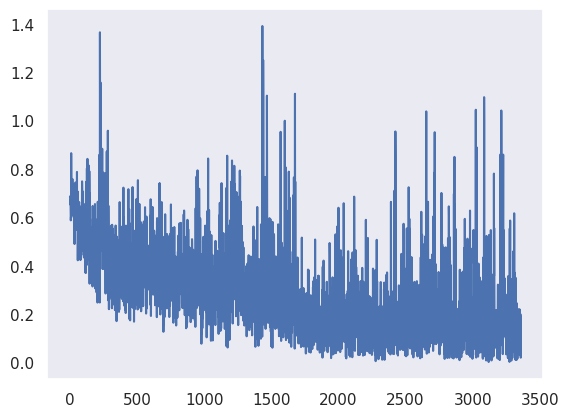

In [32]:
plt.plot(train_losses)

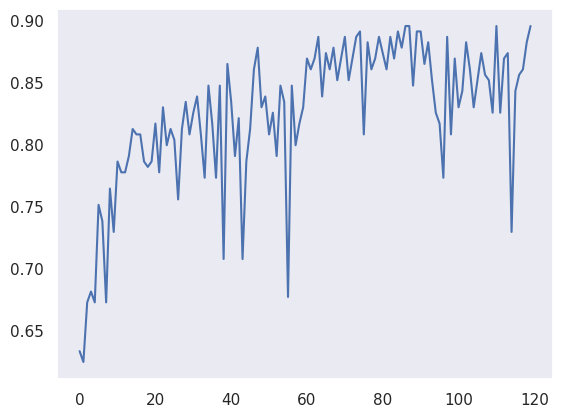

In [33]:
plt.plot(test_accuracy)

In [34]:
model_path = '../heartsound_m13_2_120epochs.pt' 
torch.save(model.state_dict(), model_path)

In [35]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 60
n_epoch4 = 80
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4 + n_epoch3 + n_epoch2+n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.05714285714285714/80 [00:00<11:46,  8.84s/it]

Train Epoch: 121 [0/913 (0%)]	Loss: 0.084693


  1%|▉                                                                            | 1.0000000000000002/80 [00:09<09:55,  7.54s/it]


Test Epoch: 121	Accuracy: 203/229 (89%)



  1%|▉                                                                            | 1.0285714285714287/80 [00:10<11:13,  8.53s/it]

Train Epoch: 122 [0/913 (0%)]	Loss: 0.034474


  2%|█▉                                                                           | 1.9999999999999967/80 [00:19<09:51,  7.58s/it]


Test Epoch: 122	Accuracy: 211/229 (92%)



  3%|██                                                                            | 2.057142857142854/80 [00:20<10:18,  7.94s/it]

Train Epoch: 123 [0/913 (0%)]	Loss: 0.032252


  4%|██▉                                                                          | 2.9999999999999933/80 [00:29<09:37,  7.50s/it]


Test Epoch: 123	Accuracy: 205/229 (90%)



  4%|██▉                                                                           | 3.028571428571422/80 [00:30<10:51,  8.46s/it]

Train Epoch: 124 [0/913 (0%)]	Loss: 0.022316


  5%|███▉                                                                           | 3.99999999999999/80 [00:39<09:44,  7.70s/it]


Test Epoch: 124	Accuracy: 206/229 (90%)



  5%|███▉                                                                          | 4.057142857142847/80 [00:40<10:21,  8.18s/it]

Train Epoch: 125 [0/913 (0%)]	Loss: 0.020421


  6%|████▊                                                                         | 4.999999999999987/80 [00:49<09:21,  7.48s/it]


Test Epoch: 125	Accuracy: 209/229 (91%)



  6%|████▉                                                                         | 5.057142857142844/80 [00:50<09:55,  7.94s/it]

Train Epoch: 126 [0/913 (0%)]	Loss: 0.057716


  7%|█████▊                                                                        | 5.999999999999983/80 [00:59<09:31,  7.73s/it]


Test Epoch: 126	Accuracy: 210/229 (92%)



  8%|█████▉                                                                         | 6.05714285714284/80 [01:00<10:00,  8.13s/it]

Train Epoch: 127 [0/913 (0%)]	Loss: 0.062107


  9%|██████▉                                                                        | 6.99999999999998/80 [01:09<09:12,  7.56s/it]


Test Epoch: 127	Accuracy: 211/229 (92%)



  9%|██████▊                                                                       | 7.028571428571408/80 [01:10<10:24,  8.55s/it]

Train Epoch: 128 [0/913 (0%)]	Loss: 0.017397


 10%|███████▊                                                                      | 7.999999999999976/80 [01:19<09:05,  7.58s/it]


Test Epoch: 128	Accuracy: 204/229 (89%)



 10%|███████▊                                                                      | 8.028571428571405/80 [01:20<10:21,  8.63s/it]

Train Epoch: 129 [0/913 (0%)]	Loss: 0.017314


 11%|████████▊                                                                     | 8.999999999999973/80 [01:29<08:58,  7.59s/it]


Test Epoch: 129	Accuracy: 211/229 (92%)



 11%|████████▉                                                                      | 9.05714285714283/80 [01:30<09:38,  8.15s/it]

Train Epoch: 130 [0/913 (0%)]	Loss: 0.040462


 12%|█████████▊                                                                     | 9.99999999999997/80 [01:39<08:53,  7.62s/it]


Test Epoch: 130	Accuracy: 207/229 (90%)



 13%|█████████▋                                                                   | 10.028571428571398/80 [01:40<10:04,  8.64s/it]

Train Epoch: 131 [0/913 (0%)]	Loss: 0.070505


 14%|██████████▌                                                                  | 10.999999999999966/80 [01:50<08:39,  7.53s/it]


Test Epoch: 131	Accuracy: 211/229 (92%)



 14%|██████████▌                                                                  | 11.028571428571395/80 [01:50<09:45,  8.49s/it]

Train Epoch: 132 [0/913 (0%)]	Loss: 0.050212


 15%|███████████▌                                                                 | 11.999999999999963/80 [01:59<08:37,  7.61s/it]


Test Epoch: 132	Accuracy: 203/229 (89%)



 15%|███████████▊                                                                  | 12.05714285714282/80 [02:00<09:03,  7.99s/it]

Train Epoch: 133 [0/913 (0%)]	Loss: 0.007528


 16%|████████████▋                                                                 | 12.99999999999996/80 [02:09<08:29,  7.60s/it]


Test Epoch: 133	Accuracy: 209/229 (91%)



 16%|████████████▌                                                                | 13.028571428571388/80 [02:10<13:20, 11.96s/it]

Train Epoch: 134 [0/913 (0%)]	Loss: 0.018865


 17%|█████████████▍                                                               | 13.999999999999956/80 [02:20<08:20,  7.59s/it]


Test Epoch: 134	Accuracy: 211/229 (92%)



 18%|█████████████▌                                                               | 14.057142857142813/80 [02:21<08:55,  8.13s/it]

Train Epoch: 135 [0/913 (0%)]	Loss: 0.012598


 19%|██████████████▍                                                              | 14.999999999999952/80 [02:30<07:59,  7.38s/it]


Test Epoch: 135	Accuracy: 209/229 (91%)



 19%|██████████████▍                                                              | 15.057142857142809/80 [02:31<08:37,  7.96s/it]

Train Epoch: 136 [0/913 (0%)]	Loss: 0.016712


 20%|███████████████▍                                                             | 15.999999999999948/80 [02:40<07:45,  7.27s/it]


Test Epoch: 136	Accuracy: 208/229 (91%)



 20%|███████████████▍                                                             | 16.057142857142807/80 [02:41<08:17,  7.77s/it]

Train Epoch: 137 [0/913 (0%)]	Loss: 0.086661


 21%|████████████████▎                                                            | 16.999999999999947/80 [02:50<07:52,  7.50s/it]


Test Epoch: 137	Accuracy: 211/229 (92%)



 21%|████████████████▍                                                            | 17.057142857142804/80 [02:51<08:21,  7.96s/it]

Train Epoch: 138 [0/913 (0%)]	Loss: 0.005704


 22%|█████████████████▎                                                           | 17.999999999999943/80 [03:00<07:40,  7.42s/it]


Test Epoch: 138	Accuracy: 212/229 (93%)



 23%|█████████████████▌                                                            | 18.02857142857137/80 [03:00<08:48,  8.53s/it]

Train Epoch: 139 [0/913 (0%)]	Loss: 0.003859


 24%|██████████████████▌                                                           | 18.99999999999994/80 [03:11<07:38,  7.51s/it]


Test Epoch: 139	Accuracy: 210/229 (92%)



 24%|██████████████████▎                                                          | 19.057142857142797/80 [03:11<08:13,  8.10s/it]

Train Epoch: 140 [0/913 (0%)]	Loss: 0.084170


 25%|███████████████████▏                                                         | 19.999999999999936/80 [03:21<07:31,  7.53s/it]


Test Epoch: 140	Accuracy: 210/229 (92%)



 25%|███████████████████▎                                                         | 20.057142857142793/80 [03:21<08:20,  8.36s/it]

Train Epoch: 141 [0/913 (0%)]	Loss: 0.001276


 26%|████████████████████▏                                                        | 20.999999999999932/80 [03:31<07:40,  7.81s/it]


Test Epoch: 141	Accuracy: 211/229 (92%)



 26%|████████████████████▌                                                         | 21.05714285714279/80 [03:31<07:58,  8.11s/it]

Train Epoch: 142 [0/913 (0%)]	Loss: 0.013344


 27%|█████████████████████▍                                                        | 21.99999999999993/80 [03:41<07:13,  7.47s/it]


Test Epoch: 142	Accuracy: 212/229 (93%)



 28%|█████████████████████▏                                                       | 22.028571428571357/80 [03:41<08:15,  8.54s/it]

Train Epoch: 143 [0/913 (0%)]	Loss: 0.001248


 29%|██████████████████████▏                                                      | 22.999999999999925/80 [03:51<07:27,  7.85s/it]


Test Epoch: 143	Accuracy: 211/229 (92%)



 29%|██████████████████████▏                                                      | 23.028571428571354/80 [03:52<08:35,  9.04s/it]

Train Epoch: 144 [0/913 (0%)]	Loss: 0.008242


 30%|███████████████████████                                                      | 23.999999999999922/80 [04:02<07:04,  7.58s/it]


Test Epoch: 144	Accuracy: 211/229 (92%)



 30%|███████████████████████▍                                                      | 24.05714285714278/80 [04:02<07:43,  8.29s/it]

Train Epoch: 145 [0/913 (0%)]	Loss: 0.000424


 31%|████████████████████████▎                                                     | 24.99999999999992/80 [04:12<06:56,  7.58s/it]


Test Epoch: 145	Accuracy: 209/229 (91%)



 31%|████████████████████████                                                     | 25.028571428571347/80 [04:12<07:51,  8.58s/it]

Train Epoch: 146 [0/913 (0%)]	Loss: 0.028341


 32%|█████████████████████████                                                    | 25.999999999999915/80 [04:22<06:43,  7.48s/it]


Test Epoch: 146	Accuracy: 211/229 (92%)



 33%|█████████████████████████                                                    | 26.028571428571343/80 [04:23<07:52,  8.75s/it]

Train Epoch: 147 [0/913 (0%)]	Loss: 0.004227


 34%|██████████████████████████▎                                                   | 26.99999999999991/80 [04:33<06:45,  7.65s/it]


Test Epoch: 147	Accuracy: 210/229 (92%)



 34%|██████████████████████████                                                   | 27.057142857142768/80 [04:33<07:08,  8.09s/it]

Train Epoch: 148 [0/913 (0%)]	Loss: 0.016078


 35%|██████████████████████████▉                                                  | 27.999999999999908/80 [04:43<06:32,  7.55s/it]


Test Epoch: 148	Accuracy: 210/229 (92%)



 35%|███████████████████████████                                                  | 28.057142857142765/80 [04:44<07:12,  8.33s/it]

Train Epoch: 149 [0/913 (0%)]	Loss: 0.000588


 36%|███████████████████████████▉                                                 | 28.999999999999904/80 [04:53<06:16,  7.39s/it]


Test Epoch: 149	Accuracy: 208/229 (91%)



 36%|████████████████████████████▎                                                 | 29.05714285714276/80 [04:54<06:42,  7.90s/it]

Train Epoch: 150 [0/913 (0%)]	Loss: 0.061388


 37%|█████████████████████████████▌                                                 | 29.9999999999999/80 [05:04<06:21,  7.62s/it]


Test Epoch: 150	Accuracy: 210/229 (92%)



 38%|█████████████████████████████▎                                                | 30.02857142857133/80 [05:04<07:08,  8.57s/it]

Train Epoch: 151 [0/913 (0%)]	Loss: 0.000167


 39%|█████████████████████████████▊                                               | 30.999999999999897/80 [05:14<06:13,  7.62s/it]


Test Epoch: 151	Accuracy: 210/229 (92%)



 39%|█████████████████████████████▉                                               | 31.057142857142754/80 [05:14<06:31,  8.00s/it]

Train Epoch: 152 [0/913 (0%)]	Loss: 0.002063


 40%|██████████████████████████████▊                                              | 31.999999999999893/80 [05:24<06:08,  7.68s/it]


Test Epoch: 152	Accuracy: 211/229 (92%)



 40%|███████████████████████████████▎                                              | 32.05714285714276/80 [05:25<06:40,  8.35s/it]

Train Epoch: 153 [0/913 (0%)]	Loss: 0.000531


 41%|███████████████████████████████▊                                             | 33.000000000000014/80 [05:35<05:57,  7.61s/it]


Test Epoch: 153	Accuracy: 212/229 (93%)



 41%|███████████████████████████████▊                                             | 33.028571428571446/80 [05:35<06:44,  8.62s/it]

Train Epoch: 154 [0/913 (0%)]	Loss: 0.009280


 43%|████████████████████████████████▋                                            | 34.000000000000135/80 [05:46<06:11,  8.07s/it]


Test Epoch: 154	Accuracy: 210/229 (92%)



 43%|█████████████████████████████████▏                                            | 34.02857142857157/80 [05:46<07:03,  9.22s/it]

Train Epoch: 155 [0/913 (0%)]	Loss: 0.022763


 44%|█████████████████████████████████▋                                           | 35.000000000000256/80 [05:57<05:58,  7.96s/it]


Test Epoch: 155	Accuracy: 207/229 (90%)



 44%|██████████████████████████████████▏                                           | 35.02857142857169/80 [05:57<06:52,  9.17s/it]

Train Epoch: 156 [0/913 (0%)]	Loss: 0.037592


 45%|███████████████████████████████████                                           | 36.00000000000038/80 [06:08<05:54,  8.05s/it]


Test Epoch: 156	Accuracy: 209/229 (91%)



 45%|███████████████████████████████████▏                                          | 36.02857142857181/80 [06:08<06:46,  9.24s/it]

Train Epoch: 157 [0/913 (0%)]	Loss: 0.013414


 46%|████████████████████████████████████▌                                          | 37.0000000000005/80 [06:18<05:44,  8.01s/it]


Test Epoch: 157	Accuracy: 210/229 (92%)



 46%|████████████████████████████████████▏                                         | 37.05714285714336/80 [06:19<06:05,  8.51s/it]

Train Epoch: 158 [0/913 (0%)]	Loss: 0.001224


 48%|█████████████████████████████████████                                         | 38.00000000000062/80 [06:29<05:41,  8.14s/it]


Test Epoch: 158	Accuracy: 210/229 (92%)



 48%|█████████████████████████████████████                                         | 38.02857142857205/80 [06:30<06:31,  9.34s/it]

Train Epoch: 159 [0/913 (0%)]	Loss: 0.001211


 49%|██████████████████████████████████████                                        | 39.00000000000074/80 [06:40<05:28,  8.00s/it]


Test Epoch: 159	Accuracy: 208/229 (91%)



 49%|██████████████████████████████████████▌                                        | 39.0571428571436/80 [06:41<05:54,  8.65s/it]

Train Epoch: 160 [0/913 (0%)]	Loss: 0.005972


 50%|███████████████████████████████████████                                       | 40.00000000000086/80 [06:51<05:18,  7.96s/it]


Test Epoch: 160	Accuracy: 206/229 (90%)



 50%|███████████████████████████████████████                                       | 40.02857142857229/80 [06:52<06:07,  9.19s/it]

Train Epoch: 161 [0/913 (0%)]	Loss: 0.041267


 51%|███████████████████████████████████████▉                                      | 41.00000000000098/80 [07:02<05:09,  7.94s/it]


Test Epoch: 161	Accuracy: 209/229 (91%)



 51%|████████████████████████████████████████                                      | 41.02857142857241/80 [07:03<05:57,  9.16s/it]

Train Epoch: 162 [0/913 (0%)]	Loss: 0.000165


 53%|█████████████████████████████████████████▍                                     | 42.0000000000011/80 [07:13<05:01,  7.95s/it]


Test Epoch: 162	Accuracy: 209/229 (91%)



 53%|████████████████████████████████████████▉                                     | 42.02857142857253/80 [07:14<05:48,  9.19s/it]

Train Epoch: 163 [0/913 (0%)]	Loss: 0.000465


 54%|█████████████████████████████████████████▉                                    | 43.00000000000122/80 [07:24<04:54,  7.95s/it]


Test Epoch: 163	Accuracy: 208/229 (91%)



 54%|█████████████████████████████████████████▍                                   | 43.057142857144086/80 [07:25<05:15,  8.53s/it]

Train Epoch: 164 [0/913 (0%)]	Loss: 0.000662


 55%|██████████████████████████████████████████▉                                   | 44.00000000000134/80 [07:35<04:50,  8.06s/it]


Test Epoch: 164	Accuracy: 212/229 (93%)



 55%|██████████████████████████████████████████▍                                  | 44.028571428572775/80 [07:36<05:33,  9.27s/it]

Train Epoch: 165 [0/913 (0%)]	Loss: 0.004933


 56%|███████████████████████████████████████████▎                                 | 45.000000000001464/80 [07:46<04:43,  8.09s/it]


Test Epoch: 165	Accuracy: 207/229 (90%)



 56%|███████████████████████████████████████████▎                                 | 45.028571428572896/80 [07:47<05:28,  9.39s/it]

Train Epoch: 166 [0/913 (0%)]	Loss: 0.000027


 58%|████████████████████████████████████████████▎                                | 46.000000000001585/80 [07:57<04:31,  8.00s/it]


Test Epoch: 166	Accuracy: 210/229 (92%)



 58%|████████████████████████████████████████████▉                                 | 46.02857142857302/80 [07:57<05:10,  9.15s/it]

Train Epoch: 167 [0/913 (0%)]	Loss: 0.000114


 59%|█████████████████████████████████████████████▏                               | 47.000000000001705/80 [08:08<04:25,  8.05s/it]


Test Epoch: 167	Accuracy: 211/229 (92%)



 59%|█████████████████████████████████████████████▊                                | 47.02857142857314/80 [08:08<05:07,  9.33s/it]

Train Epoch: 168 [0/913 (0%)]	Loss: 0.045100


 60%|██████████████████████████████████████████████▏                              | 48.000000000001826/80 [08:19<04:16,  8.02s/it]


Test Epoch: 168	Accuracy: 211/229 (92%)



 60%|██████████████████████████████████████████████▊                               | 48.02857142857326/80 [08:19<04:54,  9.20s/it]

Train Epoch: 169 [0/913 (0%)]	Loss: 0.021257


 61%|███████████████████████████████████████████████▊                              | 49.00000000000195/80 [08:30<04:10,  8.07s/it]


Test Epoch: 169	Accuracy: 210/229 (92%)



 61%|███████████████████████████████████████████████▊                              | 49.05714285714481/80 [08:31<04:26,  8.61s/it]

Train Epoch: 170 [0/913 (0%)]	Loss: 0.015160


 63%|████████████████████████████████████████████████▊                             | 50.00000000000207/80 [08:41<03:59,  7.99s/it]


Test Epoch: 170	Accuracy: 209/229 (91%)



 63%|█████████████████████████████████████████████████▍                             | 50.0285714285735/80 [08:41<04:35,  9.19s/it]

Train Epoch: 171 [0/913 (0%)]	Loss: 0.001099


 64%|█████████████████████████████████████████████████▋                            | 51.00000000000219/80 [08:52<03:54,  8.08s/it]


Test Epoch: 171	Accuracy: 207/229 (90%)



 64%|█████████████████████████████████████████████████▊                            | 51.05714285714505/80 [08:52<04:09,  8.60s/it]

Train Epoch: 172 [0/913 (0%)]	Loss: 0.000819


 65%|██████████████████████████████████████████████████▋                           | 52.00000000000231/80 [09:03<03:42,  7.94s/it]


Test Epoch: 172	Accuracy: 199/229 (87%)



 65%|██████████████████████████████████████████████████▋                           | 52.02857142857374/80 [09:03<04:18,  9.24s/it]

Train Epoch: 173 [0/913 (0%)]	Loss: 0.169667


 66%|███████████████████████████████████████████████████▋                          | 53.00000000000243/80 [09:14<03:33,  7.91s/it]


Test Epoch: 173	Accuracy: 208/229 (91%)



 66%|███████████████████████████████████████████████████                          | 53.057142857145294/80 [09:14<03:51,  8.58s/it]

Train Epoch: 174 [0/913 (0%)]	Loss: 0.002240


 68%|████████████████████████████████████████████████████▋                         | 54.00000000000255/80 [09:25<03:28,  8.03s/it]


Test Epoch: 174	Accuracy: 204/229 (89%)



 68%|████████████████████████████████████████████████████                         | 54.057142857145415/80 [09:25<03:41,  8.55s/it]

Train Epoch: 175 [0/913 (0%)]	Loss: 0.046644


 69%|█████████████████████████████████████████████████████▋                        | 55.00000000000267/80 [09:36<03:24,  8.16s/it]


Test Epoch: 175	Accuracy: 208/229 (91%)



 69%|████████████████████████████████████████████████████▉                        | 55.057142857145536/80 [09:36<03:34,  8.60s/it]

Train Epoch: 176 [0/913 (0%)]	Loss: 0.049341


 70%|██████████████████████████████████████████████████████▌                       | 56.00000000000279/80 [09:47<03:14,  8.09s/it]


Test Epoch: 176	Accuracy: 209/229 (91%)



 70%|█████████████████████████████████████████████████████▉                       | 56.028571428574224/80 [09:47<03:40,  9.19s/it]

Train Epoch: 177 [0/913 (0%)]	Loss: 0.019981


 71%|███████████████████████████████████████████████████████▌                      | 57.00000000000291/80 [09:58<03:04,  8.02s/it]


Test Epoch: 177	Accuracy: 209/229 (91%)



 71%|███████████████████████████████████████████████████████▋                      | 57.05714285714578/80 [09:58<03:21,  8.78s/it]

Train Epoch: 178 [0/913 (0%)]	Loss: 0.004782


 73%|███████████████████████████████████████████████████████▊                     | 58.000000000003034/80 [10:09<02:56,  8.04s/it]


Test Epoch: 178	Accuracy: 209/229 (91%)



 73%|███████████████████████████████████████████████████████▊                     | 58.028571428574466/80 [10:09<03:22,  9.23s/it]

Train Epoch: 179 [0/913 (0%)]	Loss: 0.000016


 74%|████████████████████████████████████████████████████████▊                    | 59.000000000003155/80 [10:20<02:50,  8.12s/it]


Test Epoch: 179	Accuracy: 208/229 (91%)



 74%|█████████████████████████████████████████████████████████▌                    | 59.05714285714602/80 [10:20<02:58,  8.54s/it]

Train Epoch: 180 [0/913 (0%)]	Loss: 0.034353


 75%|█████████████████████████████████████████████████████████▊                   | 60.000000000003276/80 [10:30<02:36,  7.83s/it]


Test Epoch: 180	Accuracy: 207/229 (90%)



 75%|██████████████████████████████████████████████████████████▌                   | 60.02857142857471/80 [10:31<03:01,  9.07s/it]

Train Epoch: 181 [0/913 (0%)]	Loss: 0.000728


 76%|██████████████████████████████████████████████████████████▋                  | 61.000000000003396/80 [10:41<02:41,  8.52s/it]


Test Epoch: 181	Accuracy: 204/229 (89%)



 76%|███████████████████████████████████████████████████████████▌                  | 61.05714285714626/80 [10:42<02:48,  8.89s/it]

Train Epoch: 182 [0/913 (0%)]	Loss: 0.003004


 78%|████████████████████████████████████████████████████████████▍                 | 62.00000000000352/80 [10:52<02:22,  7.93s/it]


Test Epoch: 182	Accuracy: 208/229 (91%)



 78%|████████████████████████████████████████████████████████████▍                 | 62.02857142857495/80 [10:53<02:46,  9.24s/it]

Train Epoch: 183 [0/913 (0%)]	Loss: 0.000136


 79%|█████████████████████████████████████████████████████████████▍                | 63.00000000000364/80 [11:03<02:17,  8.07s/it]


Test Epoch: 183	Accuracy: 209/229 (91%)



 79%|██████████████████████████████████████████████████████████████▎                | 63.0571428571465/80 [11:04<02:24,  8.53s/it]

Train Epoch: 184 [0/913 (0%)]	Loss: 0.000016


 80%|██████████████████████████████████████████████████████████████▍               | 64.00000000000375/80 [11:14<02:09,  8.09s/it]


Test Epoch: 184	Accuracy: 209/229 (91%)



 80%|███████████████████████████████████████████████████████████████▎               | 64.0571428571466/80 [11:15<02:18,  8.70s/it]

Train Epoch: 185 [0/913 (0%)]	Loss: 0.000055


 81%|███████████████████████████████████████████████████████████████▍              | 65.00000000000362/80 [11:25<01:59,  7.99s/it]


Test Epoch: 185	Accuracy: 207/229 (90%)



 81%|███████████████████████████████████████████████████████████████▍              | 65.02857142857505/80 [11:25<02:18,  9.23s/it]

Train Epoch: 186 [0/913 (0%)]	Loss: 0.000227


 83%|█████████████████████████████████████████████████████████████████▏             | 66.0000000000035/80 [11:36<01:49,  7.79s/it]


Test Epoch: 186	Accuracy: 210/229 (92%)



 83%|████████████████████████████████████████████████████████████████▍             | 66.05714285714635/80 [11:37<01:57,  8.46s/it]

Train Epoch: 187 [0/913 (0%)]	Loss: 0.000053


 84%|█████████████████████████████████████████████████████████████████▎            | 67.00000000000337/80 [11:47<01:43,  7.98s/it]


Test Epoch: 187	Accuracy: 208/229 (91%)



 84%|█████████████████████████████████████████████████████████████████▍            | 67.05714285714622/80 [11:48<01:50,  8.51s/it]

Train Epoch: 188 [0/913 (0%)]	Loss: 0.000011


 85%|██████████████████████████████████████████████████████████████████▎           | 68.00000000000324/80 [11:58<02:02, 10.23s/it]


Test Epoch: 188	Accuracy: 209/229 (91%)



 85%|██████████████████████████████████████████████████████████████████▎           | 68.05714285714609/80 [11:59<01:54,  9.58s/it]

Train Epoch: 189 [0/913 (0%)]	Loss: 0.000318


 86%|███████████████████████████████████████████████████████████████████▎          | 69.00000000000311/80 [12:09<01:30,  8.24s/it]


Test Epoch: 189	Accuracy: 207/229 (90%)



 86%|███████████████████████████████████████████████████████████████████▎          | 69.05714285714596/80 [12:10<01:34,  8.62s/it]

Train Epoch: 190 [0/913 (0%)]	Loss: 0.000001


 88%|████████████████████████████████████████████████████████████████████▎         | 70.00000000000298/80 [12:20<01:22,  8.29s/it]


Test Epoch: 190	Accuracy: 208/229 (91%)



 88%|████████████████████████████████████████████████████████████████████▎         | 70.05714285714583/80 [12:21<01:26,  8.69s/it]

Train Epoch: 191 [0/913 (0%)]	Loss: 0.000050


 89%|█████████████████████████████████████████████████████████████████████▏        | 71.00000000000286/80 [12:31<01:12,  8.06s/it]


Test Epoch: 191	Accuracy: 209/229 (91%)



 89%|█████████████████████████████████████████████████████████████████████▎        | 71.02857142857428/80 [12:31<01:21,  9.13s/it]

Train Epoch: 192 [0/913 (0%)]	Loss: 0.000005


 90%|██████████████████████████████████████████████████████████████████████▏       | 72.00000000000273/80 [12:42<01:03,  7.91s/it]


Test Epoch: 192	Accuracy: 209/229 (91%)



 90%|██████████████████████████████████████████████████████████████████████▏       | 72.02857142857415/80 [12:42<01:13,  9.16s/it]

Train Epoch: 193 [0/913 (0%)]	Loss: 0.000088


 91%|████████████████████████████████████████████████████████████████████████       | 73.0000000000026/80 [12:53<00:56,  8.11s/it]


Test Epoch: 193	Accuracy: 206/229 (90%)



 91%|███████████████████████████████████████████████████████████████████████▏      | 73.02857142857403/80 [12:53<01:05,  9.36s/it]

Train Epoch: 194 [0/913 (0%)]	Loss: 0.000100


 93%|████████████████████████████████████████████████████████████████████████▏     | 74.00000000000247/80 [13:04<00:47,  7.89s/it]


Test Epoch: 194	Accuracy: 208/229 (91%)



 93%|████████████████████████████████████████████████████████████████████████▏     | 74.05714285714532/80 [13:05<00:50,  8.58s/it]

Train Epoch: 195 [0/913 (0%)]	Loss: 0.004896


 94%|█████████████████████████████████████████████████████████████████████████▏    | 75.00000000000234/80 [13:15<00:40,  8.02s/it]


Test Epoch: 195	Accuracy: 209/229 (91%)



 94%|█████████████████████████████████████████████████████████████████████████▏    | 75.02857142857377/80 [13:15<00:45,  9.22s/it]

Train Epoch: 196 [0/913 (0%)]	Loss: 0.000250


 95%|██████████████████████████████████████████████████████████████████████████    | 76.00000000000222/80 [13:26<00:32,  8.11s/it]


Test Epoch: 196	Accuracy: 206/229 (90%)



 95%|██████████████████████████████████████████████████████████████████████████▏   | 76.02857142857364/80 [13:26<00:36,  9.22s/it]

Train Epoch: 197 [0/913 (0%)]	Loss: 0.000185


 96%|███████████████████████████████████████████████████████████████████████████   | 77.00000000000209/80 [13:37<00:23,  7.99s/it]


Test Epoch: 197	Accuracy: 205/229 (90%)



 96%|███████████████████████████████████████████████████████████████████████████   | 77.02857142857351/80 [13:37<00:27,  9.18s/it]

Train Epoch: 198 [0/913 (0%)]	Loss: 0.473076


 98%|████████████████████████████████████████████████████████████████████████████  | 78.00000000000196/80 [13:48<00:16,  8.09s/it]


Test Epoch: 198	Accuracy: 205/229 (90%)



 98%|████████████████████████████████████████████████████████████████████████████  | 78.05714285714481/80 [13:49<00:16,  8.56s/it]

Train Epoch: 199 [0/913 (0%)]	Loss: 0.000495


 99%|█████████████████████████████████████████████████████████████████████████████ | 79.00000000000183/80 [13:59<00:08,  8.08s/it]


Test Epoch: 199	Accuracy: 210/229 (92%)



 99%|█████████████████████████████████████████████████████████████████████████████ | 79.02857142857326/80 [13:59<00:08,  9.26s/it]

Train Epoch: 200 [0/913 (0%)]	Loss: 0.104610


100%|███████████████████████████████████████████████████████████████████████████████| 80.0000000000017/80 [14:10<00:00, 10.63s/it]


Test Epoch: 200	Accuracy: 207/229 (90%)



In [36]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 207/229 (0.9039)
F1: 0.9241071343421936
UAP: 0.917896032333374
WAP: 0.9241071343421936
UAR: 0.9154517650604248
WAR: 0.9241071343421936
tensor([[ 70,   9],
        [  8, 137]], device='cuda:0')


In [37]:
model_path = '../heartsound_m13_2_200epochs.pt' 
torch.save(model.state_dict(), model_path)

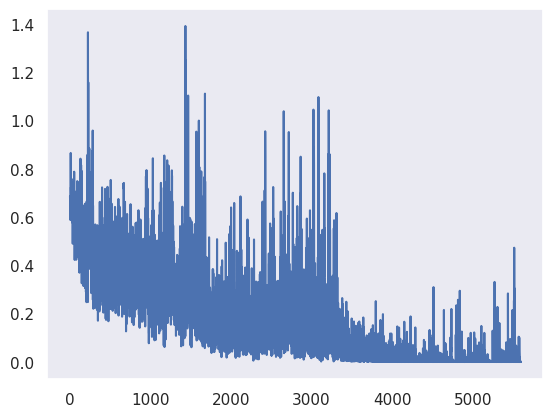

In [38]:
plt.plot(train_losses)

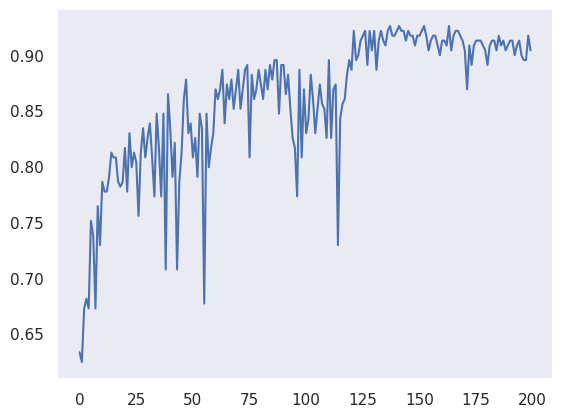

In [39]:
plt.plot(test_accuracy)

## Best: acc: 0.9214, F1: 0.94196, UAR: 0.940768

In [40]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 60
n_epoch4 = 80
n_epoch5 =50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(201, 251):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.05714285714285714/80 [00:00<11:44,  8.81s/it]

Train Epoch: 201 [0/913 (0%)]	Loss: 0.000008


  1%|▉                                                                            | 1.0000000000000002/80 [00:10<10:16,  7.80s/it]


Test Epoch: 201	Accuracy: 208/229 (91%)



  1%|▉                                                                            | 1.0285714285714287/80 [00:10<11:26,  8.70s/it]

Train Epoch: 202 [0/913 (0%)]	Loss: 0.000028


  2%|█▉                                                                           | 1.9999999999999967/80 [00:20<09:42,  7.47s/it]


Test Epoch: 202	Accuracy: 210/229 (92%)



  3%|██                                                                            | 2.057142857142854/80 [00:20<10:25,  8.03s/it]

Train Epoch: 203 [0/913 (0%)]	Loss: 0.000001


  4%|██▉                                                                          | 2.9999999999999933/80 [00:30<09:43,  7.57s/it]


Test Epoch: 203	Accuracy: 209/229 (91%)



  4%|██▉                                                                          | 3.0571428571428503/80 [00:30<10:25,  8.12s/it]

Train Epoch: 204 [0/913 (0%)]	Loss: 0.000009


  5%|███▉                                                                           | 3.99999999999999/80 [00:40<09:55,  7.83s/it]


Test Epoch: 204	Accuracy: 209/229 (91%)



  5%|███▉                                                                          | 4.057142857142847/80 [00:41<10:20,  8.17s/it]

Train Epoch: 205 [0/913 (0%)]	Loss: 0.000014


  6%|████▊                                                                         | 4.999999999999987/80 [00:50<09:21,  7.49s/it]


Test Epoch: 205	Accuracy: 208/229 (91%)



  6%|████▉                                                                         | 5.057142857142844/80 [00:51<10:09,  8.13s/it]

Train Epoch: 206 [0/913 (0%)]	Loss: 0.000011


  7%|█████▊                                                                        | 5.999999999999983/80 [01:00<08:59,  7.29s/it]


Test Epoch: 206	Accuracy: 209/229 (91%)



  8%|█████▉                                                                         | 6.05714285714284/80 [01:01<09:54,  8.04s/it]

Train Epoch: 207 [0/913 (0%)]	Loss: 0.000204


  9%|██████▉                                                                        | 6.99999999999998/80 [01:10<09:07,  7.51s/it]


Test Epoch: 207	Accuracy: 209/229 (91%)



  9%|██████▊                                                                      | 7.0571428571428365/80 [01:11<09:43,  8.00s/it]

Train Epoch: 208 [0/913 (0%)]	Loss: 0.000063


 10%|███████▊                                                                      | 7.999999999999976/80 [01:21<09:05,  7.57s/it]


Test Epoch: 208	Accuracy: 207/229 (90%)



 10%|███████▊                                                                      | 8.057142857142834/80 [01:21<09:53,  8.24s/it]

Train Epoch: 209 [0/913 (0%)]	Loss: 0.000046


 11%|████████▊                                                                     | 8.999999999999973/80 [01:31<08:53,  7.52s/it]


Test Epoch: 209	Accuracy: 208/229 (91%)



 11%|████████▉                                                                      | 9.05714285714283/80 [01:31<09:31,  8.06s/it]

Train Epoch: 210 [0/913 (0%)]	Loss: 0.000170


 12%|█████████▊                                                                     | 9.99999999999997/80 [01:41<09:05,  7.79s/it]


Test Epoch: 210	Accuracy: 210/229 (92%)



 13%|█████████▋                                                                   | 10.057142857142827/80 [01:42<09:34,  8.22s/it]

Train Epoch: 211 [0/913 (0%)]	Loss: 0.000134


 14%|██████████▌                                                                  | 10.999999999999966/80 [01:52<10:29,  9.13s/it]


Test Epoch: 211	Accuracy: 209/229 (91%)



 14%|██████████▋                                                                  | 11.057142857142823/80 [01:52<10:06,  8.79s/it]

Train Epoch: 212 [0/913 (0%)]	Loss: 0.000039


 15%|███████████▌                                                                 | 11.999999999999963/80 [02:02<09:01,  7.96s/it]


Test Epoch: 212	Accuracy: 205/229 (90%)



 15%|███████████▊                                                                  | 12.05714285714282/80 [02:02<09:49,  8.67s/it]

Train Epoch: 213 [0/913 (0%)]	Loss: 0.000014


 16%|████████████▋                                                                 | 12.99999999999996/80 [02:12<09:13,  8.26s/it]


Test Epoch: 213	Accuracy: 205/229 (90%)



 16%|████████████▌                                                                | 13.057142857142816/80 [02:13<09:25,  8.44s/it]

Train Epoch: 214 [0/913 (0%)]	Loss: 0.002792


 17%|█████████████▍                                                               | 13.999999999999956/80 [02:22<08:38,  7.86s/it]


Test Epoch: 214	Accuracy: 209/229 (91%)



 18%|█████████████▌                                                               | 14.028571428571384/80 [02:23<09:45,  8.87s/it]

Train Epoch: 215 [0/913 (0%)]	Loss: 0.000023


 19%|██████████████▍                                                              | 14.999999999999952/80 [02:33<08:16,  7.63s/it]


Test Epoch: 215	Accuracy: 212/229 (93%)



 19%|██████████████▋                                                               | 15.02857142857138/80 [02:33<09:24,  8.69s/it]

Train Epoch: 216 [0/913 (0%)]	Loss: 0.000024


 20%|███████████████▍                                                             | 15.999999999999948/80 [02:43<08:21,  7.83s/it]


Test Epoch: 216	Accuracy: 210/229 (92%)



 20%|███████████████▍                                                             | 16.057142857142807/80 [02:43<08:42,  8.18s/it]

Train Epoch: 217 [0/913 (0%)]	Loss: 0.000010


 21%|████████████████▎                                                            | 16.999999999999947/80 [02:53<08:10,  7.79s/it]


Test Epoch: 217	Accuracy: 208/229 (91%)



 21%|████████████████▍                                                            | 17.057142857142804/80 [02:53<08:33,  8.16s/it]

Train Epoch: 218 [0/913 (0%)]	Loss: 0.000004


 22%|█████████████████▎                                                           | 17.999999999999943/80 [03:03<07:48,  7.56s/it]


Test Epoch: 218	Accuracy: 211/229 (92%)



 23%|█████████████████▊                                                             | 18.0571428571428/80 [03:04<08:29,  8.23s/it]

Train Epoch: 219 [0/913 (0%)]	Loss: 0.000001


 24%|██████████████████▌                                                           | 18.99999999999994/80 [03:13<07:57,  7.83s/it]


Test Epoch: 219	Accuracy: 210/229 (92%)



 24%|██████████████████▎                                                          | 19.057142857142797/80 [03:14<08:18,  8.19s/it]

Train Epoch: 220 [0/913 (0%)]	Loss: 0.000001


 25%|███████████████████▏                                                         | 19.999999999999936/80 [03:23<07:47,  7.79s/it]


Test Epoch: 220	Accuracy: 210/229 (92%)



 25%|███████████████████▎                                                         | 20.057142857142793/80 [03:24<08:07,  8.13s/it]

Train Epoch: 221 [0/913 (0%)]	Loss: 0.000013


 26%|████████████████████▏                                                        | 20.999999999999932/80 [03:34<07:37,  7.75s/it]


Test Epoch: 221	Accuracy: 211/229 (92%)



 26%|████████████████████▌                                                         | 21.05714285714279/80 [03:34<08:08,  8.29s/it]

Train Epoch: 222 [0/913 (0%)]	Loss: 0.000008


 27%|█████████████████████▍                                                        | 21.99999999999993/80 [03:44<07:26,  7.70s/it]


Test Epoch: 222	Accuracy: 208/229 (91%)



 28%|█████████████████████▏                                                       | 22.028571428571357/80 [03:44<08:29,  8.78s/it]

Train Epoch: 223 [0/913 (0%)]	Loss: 0.000006


 29%|██████████████████████▏                                                      | 22.999999999999925/80 [03:54<07:20,  7.74s/it]


Test Epoch: 223	Accuracy: 210/229 (92%)



 29%|██████████████████████▏                                                      | 23.028571428571354/80 [03:55<08:15,  8.70s/it]

Train Epoch: 224 [0/913 (0%)]	Loss: 0.000088


 30%|███████████████████████                                                      | 23.999999999999922/80 [04:05<07:19,  7.85s/it]


Test Epoch: 224	Accuracy: 208/229 (91%)



 30%|███████████████████████▍                                                      | 24.05714285714278/80 [04:05<07:43,  8.28s/it]

Train Epoch: 225 [0/913 (0%)]	Loss: 0.000001


 31%|████████████████████████▎                                                     | 24.99999999999992/80 [04:15<07:13,  7.88s/it]


Test Epoch: 225	Accuracy: 207/229 (90%)



 31%|████████████████████████                                                     | 25.028571428571347/80 [04:15<08:10,  8.92s/it]

Train Epoch: 226 [0/913 (0%)]	Loss: 0.002070


 32%|█████████████████████████                                                    | 25.999999999999915/80 [04:25<06:51,  7.62s/it]


Test Epoch: 226	Accuracy: 208/229 (91%)



 33%|█████████████████████████                                                    | 26.028571428571343/80 [04:25<07:53,  8.77s/it]

Train Epoch: 227 [0/913 (0%)]	Loss: 0.000005


 34%|██████████████████████████▎                                                   | 26.99999999999991/80 [04:35<06:38,  7.51s/it]


Test Epoch: 227	Accuracy: 204/229 (89%)



 34%|██████████████████████████                                                   | 27.057142857142768/80 [04:36<07:10,  8.14s/it]

Train Epoch: 228 [0/913 (0%)]	Loss: 0.000342


 35%|██████████████████████████▉                                                  | 27.999999999999908/80 [04:45<06:32,  7.55s/it]


Test Epoch: 228	Accuracy: 209/229 (91%)



 35%|██████████████████████████▉                                                  | 28.028571428571336/80 [04:45<07:28,  8.63s/it]

Train Epoch: 229 [0/913 (0%)]	Loss: 0.000103


 36%|███████████████████████████▉                                                 | 28.999999999999904/80 [04:55<06:26,  7.58s/it]


Test Epoch: 229	Accuracy: 208/229 (91%)



 36%|████████████████████████████▎                                                 | 29.05714285714276/80 [04:56<07:01,  8.28s/it]

Train Epoch: 230 [0/913 (0%)]	Loss: 0.000000


 37%|█████████████████████████████▌                                                 | 29.9999999999999/80 [05:05<06:18,  7.58s/it]


Test Epoch: 230	Accuracy: 208/229 (91%)



 38%|████████████████████████████▉                                                | 30.057142857142757/80 [05:06<06:45,  8.13s/it]

Train Epoch: 231 [0/913 (0%)]	Loss: 0.000001


 39%|█████████████████████████████▊                                               | 30.999999999999897/80 [05:16<06:10,  7.57s/it]


Test Epoch: 231	Accuracy: 213/229 (93%)



 39%|█████████████████████████████▊                                               | 31.028571428571325/80 [05:16<07:02,  8.64s/it]

Train Epoch: 232 [0/913 (0%)]	Loss: 0.000044


 40%|██████████████████████████████▊                                              | 31.999999999999893/80 [05:26<06:04,  7.58s/it]


Test Epoch: 232	Accuracy: 209/229 (91%)



 40%|██████████████████████████████▊                                              | 32.028571428571325/80 [05:26<06:55,  8.67s/it]

Train Epoch: 233 [0/913 (0%)]	Loss: 0.000005


 41%|███████████████████████████████▊                                             | 33.000000000000014/80 [05:36<05:55,  7.57s/it]


Test Epoch: 233	Accuracy: 210/229 (92%)



 41%|████████████████████████████████▏                                             | 33.05714285714288/80 [05:36<06:17,  8.03s/it]

Train Epoch: 234 [0/913 (0%)]	Loss: 0.000218


 43%|████████████████████████████████▋                                            | 34.000000000000135/80 [05:46<05:54,  7.70s/it]


Test Epoch: 234	Accuracy: 210/229 (92%)



 43%|██████████████████████████████████                                              | 34.057142857143/80 [05:46<06:25,  8.38s/it]

Train Epoch: 235 [0/913 (0%)]	Loss: 0.005172


 44%|█████████████████████████████████▋                                           | 35.000000000000256/80 [05:56<05:49,  7.76s/it]


Test Epoch: 235	Accuracy: 209/229 (91%)



 44%|██████████████████████████████████▏                                           | 35.02857142857169/80 [05:57<06:42,  8.94s/it]

Train Epoch: 236 [0/913 (0%)]	Loss: 0.000336


 45%|███████████████████████████████████                                           | 36.00000000000038/80 [06:07<05:38,  7.68s/it]


Test Epoch: 236	Accuracy: 210/229 (92%)



 45%|███████████████████████████████████▏                                          | 36.05714285714324/80 [06:07<06:02,  8.25s/it]

Train Epoch: 237 [0/913 (0%)]	Loss: 0.000020


 46%|████████████████████████████████████▌                                          | 37.0000000000005/80 [06:17<07:05,  9.88s/it]


Test Epoch: 237	Accuracy: 210/229 (92%)



 46%|████████████████████████████████████▏                                         | 37.05714285714336/80 [06:18<06:36,  9.22s/it]

Train Epoch: 238 [0/913 (0%)]	Loss: 0.000000


 48%|█████████████████████████████████████                                         | 38.00000000000062/80 [06:27<05:35,  7.98s/it]


Test Epoch: 238	Accuracy: 206/229 (90%)



 48%|█████████████████████████████████████                                         | 38.02857142857205/80 [06:27<06:12,  8.88s/it]

Train Epoch: 239 [0/913 (0%)]	Loss: 0.000069


 49%|██████████████████████████████████████                                        | 39.00000000000074/80 [06:37<05:12,  7.63s/it]


Test Epoch: 239	Accuracy: 210/229 (92%)



 49%|██████████████████████████████████████                                        | 39.02857142857217/80 [06:38<05:55,  8.68s/it]

Train Epoch: 240 [0/913 (0%)]	Loss: 0.000047


 50%|███████████████████████████████████████                                       | 40.00000000000086/80 [06:47<05:02,  7.55s/it]


Test Epoch: 240	Accuracy: 209/229 (91%)



 50%|██████████████████████████████████████▌                                      | 40.057142857143724/80 [06:48<05:26,  8.18s/it]

Train Epoch: 241 [0/913 (0%)]	Loss: 0.000018


 51%|███████████████████████████████████████▉                                      | 41.00000000000098/80 [06:58<05:19,  8.20s/it]


Test Epoch: 241	Accuracy: 209/229 (91%)



 51%|███████████████████████████████████████▌                                     | 41.057142857143845/80 [06:58<05:26,  8.39s/it]

Train Epoch: 242 [0/913 (0%)]	Loss: 0.000030


 53%|█████████████████████████████████████████▍                                     | 42.0000000000011/80 [07:08<04:47,  7.57s/it]


Test Epoch: 242	Accuracy: 210/229 (92%)



 53%|████████████████████████████████████████▉                                     | 42.02857142857253/80 [07:08<05:33,  8.78s/it]

Train Epoch: 243 [0/913 (0%)]	Loss: 0.000000


 54%|█████████████████████████████████████████▉                                    | 43.00000000000122/80 [07:18<04:35,  7.45s/it]


Test Epoch: 243	Accuracy: 208/229 (91%)



 54%|█████████████████████████████████████████▍                                   | 43.028571428572654/80 [07:18<05:18,  8.62s/it]

Train Epoch: 244 [0/913 (0%)]	Loss: 0.000058


 55%|██████████████████████████████████████████▉                                   | 44.00000000000134/80 [07:28<04:33,  7.61s/it]


Test Epoch: 244	Accuracy: 203/229 (89%)



 55%|██████████████████████████████████████████▉                                   | 44.05714285714421/80 [07:29<04:49,  8.06s/it]

Train Epoch: 245 [0/913 (0%)]	Loss: 0.000476


 56%|███████████████████████████████████████████▎                                 | 45.000000000001464/80 [07:38<04:32,  7.80s/it]


Test Epoch: 245	Accuracy: 206/229 (90%)



 56%|███████████████████████████████████████████▉                                  | 45.05714285714433/80 [07:39<04:46,  8.21s/it]

Train Epoch: 246 [0/913 (0%)]	Loss: 0.000141


 58%|████████████████████████████████████████████▎                                | 46.000000000001585/80 [07:48<04:19,  7.63s/it]


Test Epoch: 246	Accuracy: 210/229 (92%)



 58%|████████████████████████████████████████████▉                                 | 46.05714285714445/80 [07:49<04:40,  8.26s/it]

Train Epoch: 247 [0/913 (0%)]	Loss: 0.002743


 59%|█████████████████████████████████████████████▏                               | 47.000000000001705/80 [07:58<04:10,  7.60s/it]


Test Epoch: 247	Accuracy: 209/229 (91%)



 59%|█████████████████████████████████████████████▉                                | 47.05714285714457/80 [07:59<04:28,  8.15s/it]

Train Epoch: 248 [0/913 (0%)]	Loss: 0.000002


 60%|██████████████████████████████████████████████▏                              | 48.000000000001826/80 [08:09<04:05,  7.67s/it]


Test Epoch: 248	Accuracy: 209/229 (91%)



 60%|██████████████████████████████████████████████▊                               | 48.05714285714469/80 [08:09<04:18,  8.08s/it]

Train Epoch: 249 [0/913 (0%)]	Loss: 0.000016


 61%|███████████████████████████████████████████████▊                              | 49.00000000000195/80 [08:19<04:03,  7.86s/it]


Test Epoch: 249	Accuracy: 210/229 (92%)



 61%|███████████████████████████████████████████████▊                              | 49.05714285714481/80 [08:20<04:14,  8.23s/it]

Train Epoch: 250 [0/913 (0%)]	Loss: 0.000031


 63%|████████████████████████████████████████████████▊                             | 50.00000000000207/80 [08:29<05:05, 10.19s/it]


Test Epoch: 250	Accuracy: 212/229 (93%)



In [41]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 211/229 (0.9214)
F1: 0.9419642686843872
UAP: 0.9336138963699341
WAP: 0.9419642686843872
UAR: 0.9407682418823242
WAR: 0.9419642686843872
tensor([[ 74,   5],
        [  8, 137]], device='cuda:0')


In [42]:
model_path = '../heartsound_m13_2_250epochs.pt' 
torch.save(model.state_dict(), model_path)

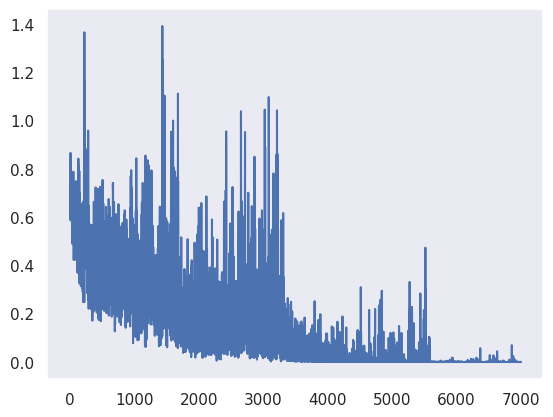

In [43]:
plt.plot(train_losses)

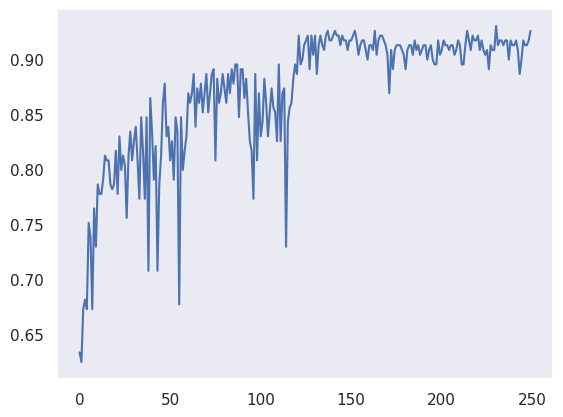

In [44]:
plt.plot(test_accuracy)

In [45]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [46]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-9.4794e-18],
        [-1.9683e-17],
        [ 9.6430e-19],
        [ 1.2613e-17],
        [-2.7298e-17],
        [-3.4879e-17],
        [-1.0291e-16],
        [-6.9057e-17],
        [ 9.7773e-18],
        [ 6.9428e-19],
        [-4.5767e-18],
        [ 6.4605e-18],
        [-6.8824e-19],
        [ 1.0856e-18],
        [-2.8326e-19],
        [ 0.0000e+00],
        [ 2.5110e-16],
        [ 3.4339e-16],
        [-5.5730e-17],
        [-1.1738e-17],
        [ 2.8143e-18],
        [ 9.5805e-18],
        [ 1.5861e-20],
        [-2.5524e-17],
        [ 5.0643e-18],
        [-8.3060e-19],
        [-3.3281e-19],
        [ 3.2173e-18],
        [ 1.8376e-18],
        [-2.0508e-18],
        [ 2.7270e-19],
        [ 0.0000e+00],
        [ 9.0448e-17],
        [ 1.0338e-18],
        [ 5.0883e-17],
        [ 2.2148e-16],
        [-6.6972e-15],
        [-3.7253e-19],
        [-6.3802e-18],
        [-2.5465e-19],
        [ 3.2324e-18],
        [-1.7601e-18],
        [-1

[None, None, None]

In [47]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

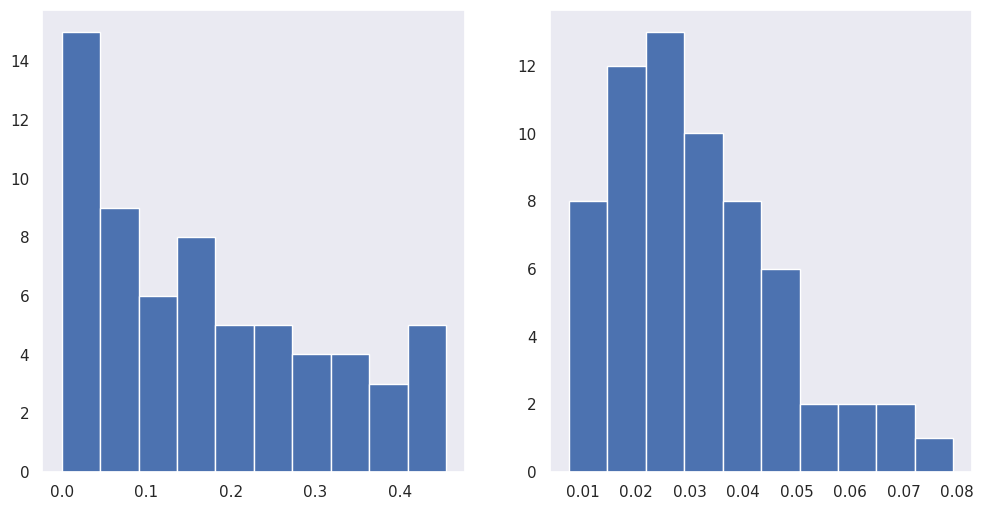

In [48]:
filtviz.visualize_bands()

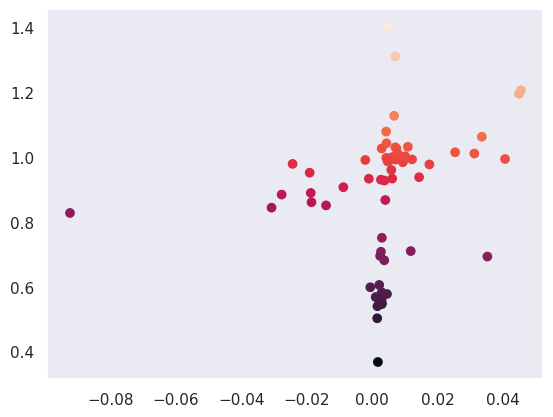

In [49]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


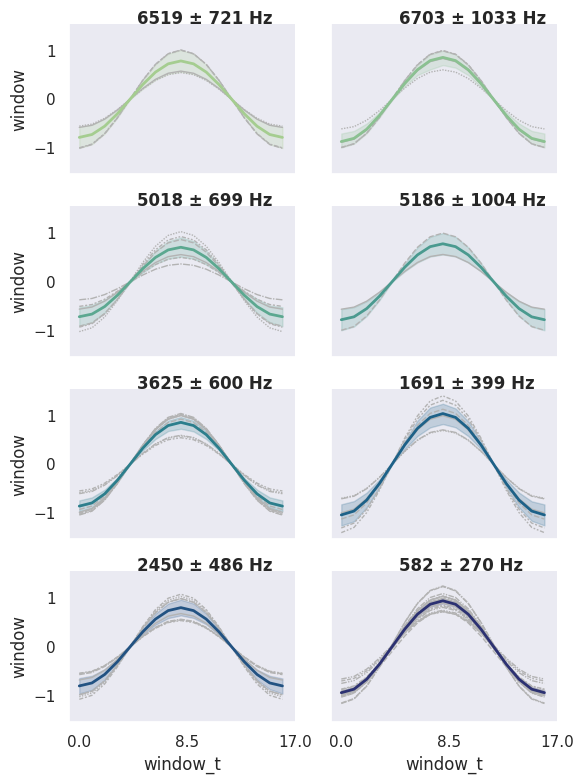

In [50]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


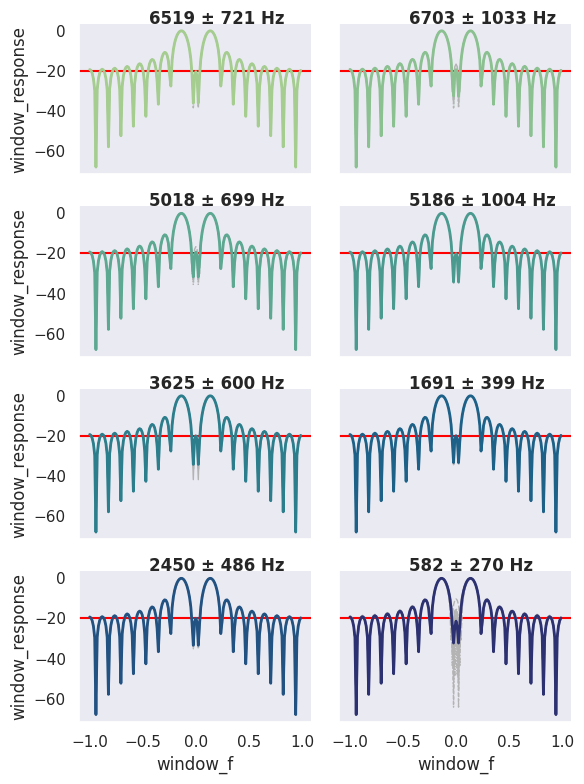

In [51]:
filtviz.visualize_filters(filter_domain='freq')

In [52]:
layer2 = model.fe_blocks.blocks[1].layer
downsample_factor = model.config.fe.stride[0]

In [53]:
filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr // downsample_factor
)

Time domain: Filters' shapes vary by frequency bins


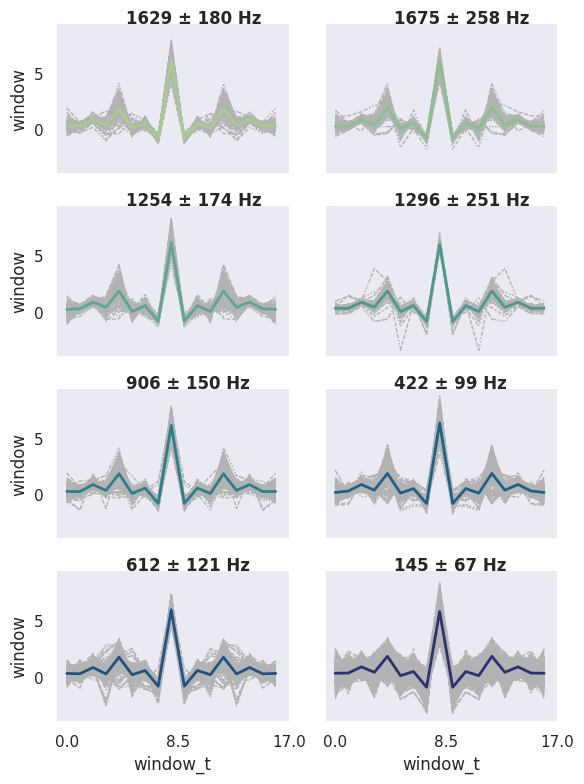

In [54]:
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


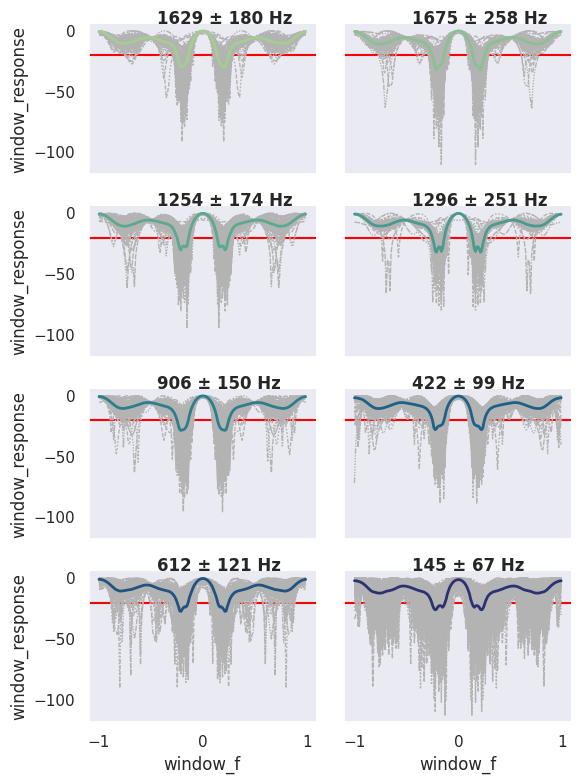

In [55]:
filtviz2.visualize_filters(filter_domain='freq')

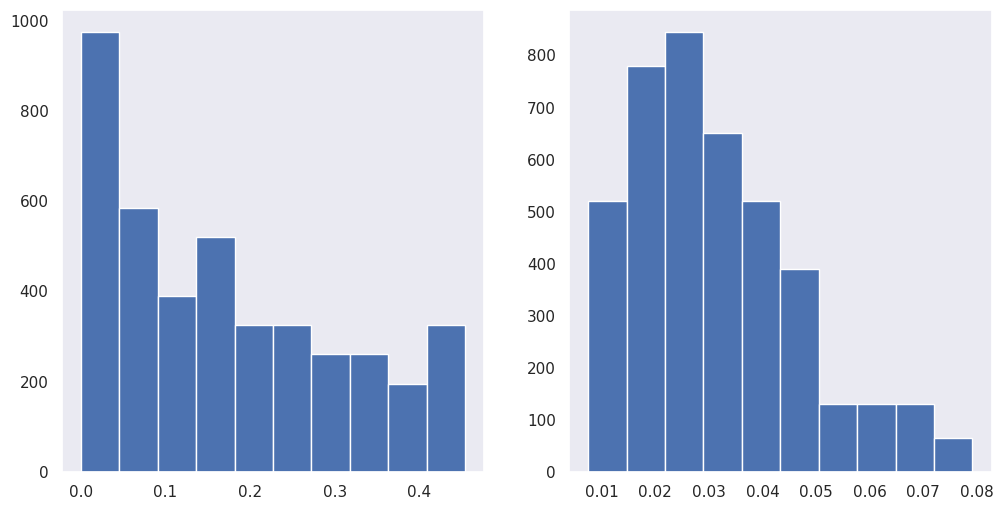

In [56]:
filtviz2.visualize_bands()

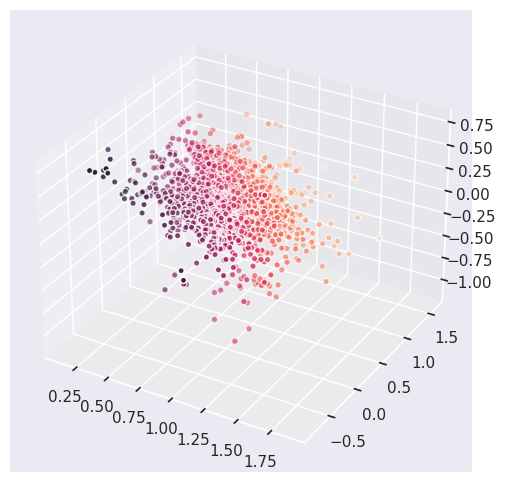

In [57]:
filtviz2.visualize_window_params()

## Other run (lower result)

In [27]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2+n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.05714285714285714/50 [00:00<07:25,  8.92s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.588600


  2%|█▌                                                                           | 1.0000000000000002/50 [00:10<06:17,  7.70s/it]


Test Epoch: 11	Accuracy: 172/229 (75%)



  2%|█▋                                                                           | 1.0571428571428572/50 [00:10<06:33,  8.05s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.551626


  4%|███                                                                          | 1.9999999999999967/50 [00:20<05:59,  7.49s/it]


Test Epoch: 12	Accuracy: 171/229 (75%)



  4%|███                                                                          | 2.0285714285714254/50 [00:20<06:52,  8.59s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.467391


  6%|████▌                                                                        | 2.9999999999999933/50 [00:30<05:44,  7.34s/it]


Test Epoch: 13	Accuracy: 174/229 (76%)



  6%|████▋                                                                         | 3.028571428571422/50 [00:30<06:34,  8.40s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.395373


  8%|██████▎                                                                        | 3.99999999999999/50 [00:40<05:56,  7.74s/it]


Test Epoch: 14	Accuracy: 175/229 (76%)



  8%|██████▎                                                                       | 4.057142857142847/50 [00:40<06:15,  8.16s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.486706


 10%|███████▊                                                                      | 4.999999999999987/50 [00:50<05:38,  7.52s/it]


Test Epoch: 15	Accuracy: 175/229 (76%)



 10%|███████▉                                                                      | 5.057142857142844/50 [00:51<05:56,  7.94s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.405861


 12%|█████████▎                                                                    | 5.999999999999983/50 [01:00<05:30,  7.52s/it]


Test Epoch: 16	Accuracy: 165/229 (72%)



 12%|█████████▌                                                                     | 6.05714285714284/50 [01:01<05:54,  8.08s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.222508


 14%|███████████                                                                    | 6.99999999999998/50 [01:10<05:15,  7.33s/it]


Test Epoch: 17	Accuracy: 173/229 (76%)



 14%|██████████▊                                                                  | 7.0571428571428365/50 [01:10<05:39,  7.90s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.361800


 16%|████████████▍                                                                 | 7.999999999999976/50 [01:20<05:13,  7.46s/it]


Test Epoch: 18	Accuracy: 175/229 (76%)



 16%|████████████▌                                                                 | 8.028571428571405/50 [01:20<05:55,  8.46s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.492457


 18%|██████████████                                                                | 8.999999999999973/50 [01:30<04:57,  7.26s/it]


Test Epoch: 19	Accuracy: 177/229 (77%)



 18%|██████████████▎                                                                | 9.05714285714283/50 [01:30<05:26,  7.97s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.380598


 20%|███████████████▊                                                               | 9.99999999999997/50 [01:40<04:58,  7.47s/it]


Test Epoch: 20	Accuracy: 140/229 (61%)



 20%|███████████████▍                                                             | 10.057142857142827/50 [01:40<05:18,  7.96s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.449061


 22%|████████████████▉                                                            | 10.999999999999966/50 [01:50<04:45,  7.32s/it]


Test Epoch: 21	Accuracy: 169/229 (74%)



 22%|█████████████████                                                            | 11.057142857142823/50 [01:50<05:08,  7.92s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.451020


 24%|██████████████████▍                                                          | 11.999999999999963/50 [02:00<04:42,  7.44s/it]


Test Epoch: 22	Accuracy: 173/229 (76%)



 24%|██████████████████▌                                                          | 12.028571428571391/50 [02:00<05:20,  8.44s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.498366


 26%|████████████████████▎                                                         | 12.99999999999996/50 [02:10<04:25,  7.17s/it]


Test Epoch: 23	Accuracy: 174/229 (76%)



 26%|████████████████████                                                         | 13.028571428571388/50 [02:10<05:05,  8.28s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.448070


 28%|█████████████████████▌                                                       | 13.999999999999956/50 [02:19<04:20,  7.23s/it]


Test Epoch: 24	Accuracy: 170/229 (74%)



 28%|█████████████████████▋                                                       | 14.057142857142813/50 [02:20<04:41,  7.82s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.268794


 30%|███████████████████████                                                      | 14.999999999999952/50 [02:29<04:18,  7.39s/it]


Test Epoch: 25	Accuracy: 173/229 (76%)



 30%|███████████████████████▏                                                     | 15.057142857142809/50 [02:30<04:34,  7.86s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.413425


 32%|████████████████████████▋                                                    | 15.999999999999948/50 [02:39<04:08,  7.30s/it]


Test Epoch: 26	Accuracy: 174/229 (76%)



 32%|████████████████████████▋                                                    | 16.057142857142807/50 [02:40<04:26,  7.86s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.455117


 34%|██████████████████████████▏                                                  | 16.999999999999947/50 [02:49<03:54,  7.10s/it]


Test Epoch: 27	Accuracy: 170/229 (74%)



 34%|██████████████████████████▎                                                  | 17.057142857142804/50 [02:50<04:18,  7.84s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.447429


 36%|███████████████████████████▋                                                 | 17.999999999999943/50 [02:59<03:56,  7.38s/it]


Test Epoch: 28	Accuracy: 175/229 (76%)



 36%|████████████████████████████                                                  | 18.02857142857137/50 [02:59<04:29,  8.44s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.601202


 38%|█████████████████████████████▋                                                | 18.99999999999994/50 [03:09<03:52,  7.49s/it]


Test Epoch: 29	Accuracy: 174/229 (76%)



 38%|█████████████████████████████▎                                               | 19.057142857142797/50 [03:10<05:08,  9.98s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.367090


 40%|██████████████████████████████▊                                              | 19.999999999999936/50 [03:20<03:44,  7.49s/it]


Test Epoch: 30	Accuracy: 175/229 (76%)



 40%|██████████████████████████████▉                                              | 20.057142857142793/50 [03:20<04:08,  8.30s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.459341


 42%|████████████████████████████████▎                                            | 20.999999999999932/50 [03:30<03:36,  7.47s/it]


Test Epoch: 31	Accuracy: 176/229 (77%)



 42%|████████████████████████████████▊                                             | 21.02857142857136/50 [03:30<04:06,  8.50s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.490401


 44%|██████████████████████████████████▎                                           | 21.99999999999993/50 [03:40<04:26,  9.50s/it]


Test Epoch: 32	Accuracy: 141/229 (62%)



 44%|█████████████████████████████████▉                                           | 22.057142857142786/50 [03:41<04:10,  8.96s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.492934


 46%|███████████████████████████████████▍                                         | 22.999999999999925/50 [03:50<03:21,  7.48s/it]


Test Epoch: 33	Accuracy: 173/229 (76%)



 46%|███████████████████████████████████▍                                         | 23.028571428571354/50 [03:51<03:49,  8.50s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.519670


 48%|████████████████████████████████████▉                                        | 23.999999999999922/50 [04:00<03:14,  7.47s/it]


Test Epoch: 34	Accuracy: 176/229 (77%)



 48%|█████████████████████████████████████▍                                        | 24.02857142857135/50 [04:01<03:42,  8.58s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.277084


 50%|██████████████████████████████████████▉                                       | 24.99999999999992/50 [04:11<03:08,  7.53s/it]


Test Epoch: 35	Accuracy: 174/229 (76%)



 50%|██████████████████████████████████████▌                                      | 25.028571428571347/50 [04:11<03:39,  8.79s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.300682


 52%|████████████████████████████████████████                                     | 25.999999999999915/50 [04:21<03:03,  7.64s/it]


Test Epoch: 36	Accuracy: 172/229 (75%)



 52%|████████████████████████████████████████                                     | 26.028571428571343/50 [04:21<03:26,  8.63s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.497831


 54%|██████████████████████████████████████████                                    | 26.99999999999991/50 [04:31<02:52,  7.48s/it]


Test Epoch: 37	Accuracy: 166/229 (72%)



 54%|█████████████████████████████████████████▋                                   | 27.057142857142768/50 [04:32<03:05,  8.10s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.345104


 56%|███████████████████████████████████████████                                  | 27.999999999999908/50 [04:41<02:46,  7.56s/it]


Test Epoch: 38	Accuracy: 166/229 (72%)



 56%|███████████████████████████████████████████▏                                 | 28.057142857142765/50 [04:42<02:58,  8.15s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.407220


 58%|████████████████████████████████████████████▋                                | 28.999999999999904/50 [04:52<02:56,  8.43s/it]


Test Epoch: 39	Accuracy: 173/229 (76%)



 58%|█████████████████████████████████████████████▎                                | 29.05714285714276/50 [04:52<02:56,  8.42s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.386864


 60%|███████████████████████████████████████████████▍                               | 29.9999999999999/50 [05:02<02:26,  7.30s/it]


Test Epoch: 40	Accuracy: 173/229 (76%)



 60%|██████████████████████████████████████████████▎                              | 30.057142857142757/50 [05:02<02:38,  7.95s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.473986


 62%|███████████████████████████████████████████████▋                             | 30.999999999999897/50 [05:12<02:17,  7.26s/it]


Test Epoch: 41	Accuracy: 174/229 (76%)



 62%|███████████████████████████████████████████████▊                             | 31.057142857142754/50 [05:12<02:28,  7.84s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.279555


 64%|█████████████████████████████████████████████████▎                           | 31.999999999999893/50 [05:22<02:26,  8.14s/it]


Test Epoch: 42	Accuracy: 172/229 (75%)



 64%|██████████████████████████████████████████████████                            | 32.05714285714276/50 [05:22<02:30,  8.37s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.232394


 66%|██████████████████████████████████████████████████▊                          | 33.000000000000014/50 [05:32<02:03,  7.29s/it]


Test Epoch: 43	Accuracy: 168/229 (73%)



 66%|██████████████████████████████████████████████████▊                          | 33.028571428571446/50 [05:32<02:22,  8.41s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.386516


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000135/50 [05:42<01:56,  7.27s/it]


Test Epoch: 44	Accuracy: 176/229 (77%)



 68%|██████████████████████████████████████████████████████▍                         | 34.057142857143/50 [05:42<02:09,  8.12s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.210683


 70%|█████████████████████████████████████████████████████▉                       | 35.000000000000256/50 [05:51<01:51,  7.40s/it]


Test Epoch: 45	Accuracy: 156/229 (68%)



 70%|██████████████████████████████████████████████████████▋                       | 35.05714285714312/50 [05:52<01:59,  7.96s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.541008


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000038/50 [06:01<01:41,  7.25s/it]


Test Epoch: 46	Accuracy: 173/229 (76%)



 72%|████████████████████████████████████████████████████████▏                     | 36.05714285714324/50 [06:02<01:51,  7.98s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.256549


 74%|██████████████████████████████████████████████████████████▍                    | 37.0000000000005/50 [06:11<01:34,  7.30s/it]


Test Epoch: 47	Accuracy: 167/229 (73%)



 74%|█████████████████████████████████████████████████████████▊                    | 37.05714285714336/50 [06:12<01:42,  7.96s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.552975


 76%|███████████████████████████████████████████████████████████▎                  | 38.00000000000062/50 [06:21<01:27,  7.26s/it]


Test Epoch: 48	Accuracy: 174/229 (76%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.05714285714348/50 [06:22<01:34,  7.94s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.386622


 78%|████████████████████████████████████████████████████████████▊                 | 39.00000000000074/50 [06:31<01:23,  7.62s/it]


Test Epoch: 49	Accuracy: 176/229 (77%)



 78%|█████████████████████████████████████████████████████████████▋                 | 39.0571428571436/50 [06:32<01:29,  8.16s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.511970


 80%|██████████████████████████████████████████████████████████████▍               | 40.00000000000086/50 [06:41<01:13,  7.39s/it]


Test Epoch: 50	Accuracy: 176/229 (77%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.057142857143724/50 [06:42<01:18,  7.90s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.360622


 82%|███████████████████████████████████████████████████████████████▉              | 41.00000000000098/50 [06:51<01:06,  7.36s/it]


Test Epoch: 51	Accuracy: 175/229 (76%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.057142857143845/50 [06:52<01:11,  8.00s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.284587


 84%|██████████████████████████████████████████████████████████████████▎            | 42.0000000000011/50 [07:01<00:58,  7.34s/it]


Test Epoch: 52	Accuracy: 178/229 (78%)



 84%|████████████████████████████████████████████████████████████████▊            | 42.057142857143965/50 [07:02<01:03,  8.04s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.287106


 86%|███████████████████████████████████████████████████████████████████           | 43.00000000000122/50 [07:11<00:51,  7.30s/it]


Test Epoch: 53	Accuracy: 179/229 (78%)



 86%|██████████████████████████████████████████████████████████████████▎          | 43.028571428572654/50 [07:12<00:58,  8.39s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.321437


 88%|████████████████████████████████████████████████████████████████████▋         | 44.00000000000134/50 [07:21<00:44,  7.37s/it]


Test Epoch: 54	Accuracy: 169/229 (74%)



 88%|███████████████████████████████████████████████████████████████████▊         | 44.028571428572775/50 [07:22<00:50,  8.52s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.575351


 90%|█████████████████████████████████████████████████████████████████████▎       | 45.000000000001464/50 [07:31<00:36,  7.39s/it]


Test Epoch: 55	Accuracy: 180/229 (79%)



 90%|██████████████████████████████████████████████████████████████████████▎       | 45.05714285714433/50 [07:32<00:39,  8.01s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.317671


 92%|██████████████████████████████████████████████████████████████████████▊      | 46.000000000001585/50 [07:42<00:29,  7.47s/it]


Test Epoch: 56	Accuracy: 176/229 (77%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.05714285714445/50 [07:42<00:31,  7.88s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.244692


 94%|████████████████████████████████████████████████████████████████████████▍    | 47.000000000001705/50 [07:51<00:22,  7.37s/it]


Test Epoch: 57	Accuracy: 180/229 (79%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02857142857314/50 [07:52<00:25,  8.42s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.304467


 96%|█████████████████████████████████████████████████████████████████████████▉   | 48.000000000001826/50 [08:01<00:14,  7.28s/it]


Test Epoch: 58	Accuracy: 178/229 (78%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02857142857326/50 [08:02<00:16,  8.42s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.127492


 98%|████████████████████████████████████████████████████████████████████████████▍ | 49.00000000000195/50 [08:12<00:07,  7.47s/it]


Test Epoch: 59	Accuracy: 177/229 (77%)



 98%|████████████████████████████████████████████████████████████████████████████▍ | 49.02857142857338/50 [08:12<00:08,  8.59s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.275824


100%|████████████████████████████████████████████████████████████████████████████▉| 49.971428571430636/50 [08:21<00:00,  7.42s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████████████| 50.00000000000207/50 [08:22<00:00, 10.04s/it]


Test Epoch: 60	Accuracy: 184/229 (80%)



In [28]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 184/229 (0.8035)
F1: 0.8214285969734192
UAP: 0.8560606241226196
WAP: 0.8214285969734192
UAR: 0.7611111402511597
WAR: 0.8214285969734192
tensor([[ 44,  36],
        [  4, 140]], device='cuda:0')


In [29]:
model_path = '../heartsound_m13_60epochs.pt' 
torch.save(model.state_dict(), model_path)

In [44]:
# n_epoch = 10
# n_epoch2 = 50
# # train_losses = []
# # test_accuracy = []
# optimizer = optim.RAdam(model.parameters(), lr=0.00005)
# scheduler = optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.05,
#     steps_per_epoch=len(train_loader), epochs=n_epoch2)

# log_interval = 40
# pbar_update = 1 / (len(train_loader) + len(test_loader))
# # model.to(device)
# with tqdm(total=n_epoch2) as pbar:
#     for epoch in range(1+n_epoch, n_epoch2+n_epoch + 1):
#         train(model, epoch, log_interval, train_losses)
#         acc = test(model, epoch)
#         test_accuracy += [acc]
#         scheduler.step()

  0%|                                                                           | 0.014084507042253521/50 [00:00<41:00, 49.22s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.521257


  1%|▉                                                                             | 0.577464788732394/50 [00:21<34:54, 42.37s/it]

Train Epoch: 11 [640/913 (4%)]	Loss: 0.456999


  2%|█▌                                                                           | 0.9999999999999991/50 [00:32<12:47, 15.66s/it]


Test Epoch: 11	Accuracy: 168/229 (73%)



  2%|█▌                                                                           | 1.0140845070422526/50 [00:32<18:04, 22.14s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.573484


  3%|██▍                                                                          | 1.5774647887323927/50 [00:53<34:37, 42.91s/it]

Train Epoch: 12 [640/913 (4%)]	Loss: 0.562340


  4%|███                                                                          | 1.9999999999999978/50 [01:04<13:00, 16.27s/it]


Test Epoch: 12	Accuracy: 166/229 (72%)



  4%|███                                                                          | 2.0140845070422513/50 [01:05<17:55, 22.42s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.384530


  5%|███▉                                                                         | 2.5774647887323914/50 [01:25<34:09, 43.21s/it]

Train Epoch: 13 [640/913 (4%)]	Loss: 0.416010


  6%|████▌                                                                        | 2.9999999999999964/50 [01:37<12:34, 16.05s/it]


Test Epoch: 13	Accuracy: 168/229 (73%)



  6%|████▊                                                                          | 3.01408450704225/50 [01:37<17:35, 22.46s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.502095


  7%|█████▋                                                                         | 3.57746478873239/50 [02:00<38:32, 49.81s/it]

Train Epoch: 14 [640/913 (4%)]	Loss: 0.751583


  8%|██████▏                                                                       | 3.999999999999995/50 [02:12<12:58, 16.92s/it]


Test Epoch: 14	Accuracy: 167/229 (73%)



  8%|██████▎                                                                       | 4.014084507042249/50 [02:13<18:53, 24.64s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.463080


  9%|███████                                                                      | 4.5774647887324065/50 [02:37<37:29, 49.53s/it]

Train Epoch: 15 [640/913 (4%)]	Loss: 0.721649


 10%|███████▊                                                                      | 5.000000000000025/50 [02:49<12:36, 16.81s/it]


Test Epoch: 15	Accuracy: 166/229 (72%)



 10%|███████▊                                                                      | 5.014084507042279/50 [02:50<18:21, 24.49s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.633321


 11%|████████▋                                                                     | 5.577464788732437/50 [03:14<36:39, 49.51s/it]

Train Epoch: 16 [640/913 (4%)]	Loss: 0.424573


 12%|█████████▎                                                                    | 6.000000000000055/50 [03:26<12:19, 16.81s/it]


Test Epoch: 16	Accuracy: 168/229 (73%)



 12%|█████████▍                                                                    | 6.014084507042309/50 [03:27<17:58, 24.51s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.406936


 13%|██████████▎                                                                   | 6.577464788732467/50 [03:50<35:48, 49.48s/it]

Train Epoch: 17 [640/913 (4%)]	Loss: 0.348384


 14%|██████████▉                                                                   | 7.000000000000085/50 [04:03<12:25, 17.34s/it]


Test Epoch: 17	Accuracy: 161/229 (70%)



 14%|██████████▉                                                                   | 7.014084507042339/50 [04:04<17:48, 24.85s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.462081


 15%|███████████▊                                                                  | 7.577464788732497/50 [04:27<35:02, 49.57s/it]

Train Epoch: 18 [640/913 (4%)]	Loss: 0.398425


 16%|████████████▍                                                                 | 8.000000000000115/50 [04:40<11:47, 16.85s/it]


Test Epoch: 18	Accuracy: 165/229 (72%)



 16%|████████████▋                                                                  | 8.01408450704237/50 [04:41<17:08, 24.49s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.414344


 17%|█████████████▍                                                                | 8.577464788732527/50 [05:04<34:13, 49.58s/it]

Train Epoch: 19 [640/913 (4%)]	Loss: 0.611304


 18%|██████████████                                                                | 9.000000000000146/50 [05:17<11:35, 16.97s/it]


Test Epoch: 19	Accuracy: 173/229 (76%)



 18%|██████████████▍                                                                 | 9.0140845070424/50 [05:17<16:45, 24.53s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.403157


 19%|██████████████▉                                                               | 9.577464788732557/50 [05:41<33:20, 49.50s/it]

Train Epoch: 20 [640/913 (4%)]	Loss: 0.649220


 20%|███████████████▍                                                             | 10.000000000000176/50 [05:54<11:08, 16.71s/it]


Test Epoch: 20	Accuracy: 165/229 (72%)



 20%|███████████████▌                                                              | 10.01408450704243/50 [05:54<16:06, 24.16s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.475085


 21%|████████████████▎                                                            | 10.577464788732588/50 [06:18<32:31, 49.50s/it]

Train Epoch: 21 [640/913 (4%)]	Loss: 0.479827


 22%|████████████████▉                                                            | 11.000000000000206/50 [06:30<11:10, 17.20s/it]


Test Epoch: 21	Accuracy: 150/229 (66%)



 22%|█████████████████▏                                                            | 11.01408450704246/50 [06:31<16:05, 24.76s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.679548


 23%|█████████████████▊                                                           | 11.577464788732618/50 [06:55<31:43, 49.53s/it]

Train Epoch: 22 [640/913 (4%)]	Loss: 1.122356


 24%|██████████████████▍                                                          | 12.000000000000236/50 [07:07<10:42, 16.90s/it]


Test Epoch: 22	Accuracy: 166/229 (72%)



 24%|██████████████████▋                                                           | 12.01408450704249/50 [07:08<15:35, 24.64s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.327580


 25%|███████████████████▎                                                         | 12.577464788732648/50 [07:31<30:53, 49.52s/it]

Train Epoch: 23 [640/913 (4%)]	Loss: 0.388341


 26%|████████████████████                                                         | 13.000000000000266/50 [07:44<10:22, 16.83s/it]


Test Epoch: 23	Accuracy: 164/229 (72%)



 26%|████████████████████▎                                                         | 13.01408450704252/50 [07:45<15:04, 24.46s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.389406


 27%|████████████████████▉                                                        | 13.577464788732678/50 [08:08<30:03, 49.53s/it]

Train Epoch: 24 [640/913 (4%)]	Loss: 0.446249


 28%|█████████████████████▌                                                       | 14.000000000000297/50 [08:21<10:11, 16.98s/it]


Test Epoch: 24	Accuracy: 167/229 (73%)



 28%|█████████████████████▊                                                        | 14.01408450704255/50 [08:22<14:45, 24.61s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.524427


 29%|██████████████████████▍                                                      | 14.577464788732708/50 [08:45<29:13, 49.49s/it]

Train Epoch: 25 [640/913 (4%)]	Loss: 0.610825


 30%|███████████████████████                                                      | 15.000000000000327/50 [08:58<09:49, 16.83s/it]


Test Epoch: 25	Accuracy: 169/229 (74%)



 30%|███████████████████████▍                                                      | 15.01408450704258/50 [08:58<14:15, 24.45s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.467759


 31%|███████████████████████▉                                                     | 15.577464788732739/50 [09:22<28:25, 49.54s/it]

Train Epoch: 26 [640/913 (4%)]	Loss: 1.133842


 32%|████████████████████████▋                                                    | 16.000000000000355/50 [09:35<09:32, 16.83s/it]


Test Epoch: 26	Accuracy: 164/229 (72%)



 32%|████████████████████████▋                                                    | 16.014084507042607/50 [09:35<13:50, 24.44s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.646900


 33%|█████████████████████████▌                                                   | 16.577464788732694/50 [09:59<27:35, 49.54s/it]

Train Epoch: 27 [640/913 (4%)]	Loss: 0.190559


 34%|██████████████████████████▌                                                   | 17.00000000000026/50 [10:12<09:20, 16.98s/it]


Test Epoch: 27	Accuracy: 167/229 (73%)



 34%|██████████████████████████▌                                                   | 17.01408450704251/50 [10:12<13:25, 24.42s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.272606


 35%|███████████████████████████▊                                                   | 17.5774647887326/50 [10:36<26:45, 49.53s/it]

Train Epoch: 28 [640/913 (4%)]	Loss: 0.220668


 36%|███████████████████████████▋                                                 | 18.000000000000163/50 [10:48<08:59, 16.87s/it]


Test Epoch: 28	Accuracy: 166/229 (72%)



 36%|███████████████████████████▋                                                 | 18.014084507042416/50 [10:49<13:04, 24.53s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.070592


 37%|████████████████████████████▌                                                | 18.577464788732502/50 [11:13<25:54, 49.46s/it]

Train Epoch: 29 [640/913 (4%)]	Loss: 0.351689


 38%|█████████████████████████████▎                                               | 19.000000000000068/50 [11:25<08:41, 16.83s/it]


Test Epoch: 29	Accuracy: 164/229 (72%)



 38%|█████████████████████████████▋                                                | 19.01408450704232/50 [11:26<12:44, 24.66s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.361802


 39%|██████████████████████████████▏                                              | 19.577464788732406/50 [11:48<22:05, 43.57s/it]

Train Epoch: 30 [640/913 (4%)]	Loss: 0.122163


 40%|███████████████████████████████▏                                              | 19.99999999999997/50 [12:00<08:02, 16.10s/it]


Test Epoch: 30	Accuracy: 160/229 (70%)



 40%|██████████████████████████████▊                                              | 20.014084507042224/50 [12:00<11:07, 22.26s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.456886


 41%|████████████████████████████████                                              | 20.57746478873231/50 [12:21<21:45, 44.38s/it]

Train Epoch: 31 [640/913 (4%)]	Loss: 0.250605


 42%|████████████████████████████████▎                                            | 20.999999999999876/50 [12:33<07:53, 16.33s/it]


Test Epoch: 31	Accuracy: 168/229 (73%)



 42%|████████████████████████████████▎                                            | 21.014084507042128/50 [12:34<11:10, 23.12s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.246095


 43%|█████████████████████████████████▏                                           | 21.577464788732215/50 [12:55<20:45, 43.84s/it]

Train Epoch: 32 [640/913 (4%)]	Loss: 0.314939


 44%|██████████████████████████████████▎                                           | 21.99999999999978/50 [13:06<07:32, 16.17s/it]


Test Epoch: 32	Accuracy: 172/229 (75%)



 44%|█████████████████████████████████▉                                           | 22.014084507042032/50 [13:07<10:59, 23.55s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.028773


 45%|███████████████████████████████████▏                                          | 22.57746478873212/50 [13:28<20:10, 44.15s/it]

Train Epoch: 33 [640/913 (4%)]	Loss: 0.266055


 46%|███████████████████████████████████▍                                         | 22.999999999999684/50 [13:40<07:17, 16.19s/it]


Test Epoch: 33	Accuracy: 167/229 (73%)



 46%|███████████████████████████████████▍                                         | 23.014084507041936/50 [13:40<10:13, 22.74s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.311389


 47%|████████████████████████████████████▎                                        | 23.577464788732023/50 [14:02<19:31, 44.35s/it]

Train Epoch: 34 [640/913 (4%)]	Loss: 0.230192


 48%|████████████████████████████████████▉                                        | 23.999999999999588/50 [14:13<07:16, 16.78s/it]


Test Epoch: 34	Accuracy: 170/229 (74%)



 48%|█████████████████████████████████████▍                                        | 24.01408450704184/50 [14:14<09:58, 23.02s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.298266


 49%|█████████████████████████████████████▊                                       | 24.577464788731927/50 [14:35<19:03, 44.97s/it]

Train Epoch: 35 [640/913 (4%)]	Loss: 0.120385


 50%|██████████████████████████████████████▍                                      | 24.999999999999492/50 [14:47<06:34, 15.77s/it]


Test Epoch: 35	Accuracy: 168/229 (73%)



 50%|██████████████████████████████████████▌                                      | 25.014084507041744/50 [14:47<09:16, 22.26s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.065120


 51%|███████████████████████████████████████▉                                      | 25.57746478873183/50 [15:08<18:21, 45.09s/it]

Train Epoch: 36 [640/913 (4%)]	Loss: 0.120628


 52%|████████████████████████████████████████                                     | 25.999999999999396/50 [15:20<06:25, 16.05s/it]


Test Epoch: 36	Accuracy: 168/229 (73%)



 52%|████████████████████████████████████████                                     | 26.014084507041648/50 [15:21<09:03, 22.66s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.162019


 53%|████████████████████████████████████████▉                                    | 26.577464788731735/50 [15:42<17:16, 44.24s/it]

Train Epoch: 37 [640/913 (4%)]	Loss: 0.235410


 54%|██████████████████████████████████████████▋                                    | 26.9999999999993/50 [15:53<06:14, 16.29s/it]


Test Epoch: 37	Accuracy: 170/229 (74%)



 54%|█████████████████████████████████████████▌                                   | 27.014084507041552/50 [15:54<08:42, 22.75s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.035756


 55%|███████████████████████████████████████████                                   | 27.57746478873164/50 [16:15<16:43, 44.77s/it]

Train Epoch: 38 [640/913 (4%)]	Loss: 0.177095


 56%|███████████████████████████████████████████                                  | 27.999999999999204/50 [16:27<06:02, 16.48s/it]


Test Epoch: 38	Accuracy: 163/229 (71%)



 56%|███████████████████████████████████████████▏                                 | 28.014084507041456/50 [16:28<08:30, 23.20s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.194934


 57%|████████████████████████████████████████████                                 | 28.577464788731543/50 [16:49<15:52, 44.44s/it]

Train Epoch: 39 [640/913 (4%)]	Loss: 0.226978


 58%|█████████████████████████████████████████████▏                                | 28.99999999999911/50 [17:01<05:37, 16.05s/it]


Test Epoch: 39	Accuracy: 164/229 (72%)



 58%|█████████████████████████████████████████████▎                                | 29.01408450704136/50 [17:01<07:57, 22.74s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.067453


 58%|█████████████████████████████████████████████                                | 29.239436619717395/50 [17:09<13:07, 37.93s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9a56a8ef40>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 59%|█████████████████████████████████████████████                                | 29.253521126759647/50 [17:10<12:11, 35.24s/it]


KeyboardInterrupt: 

In [57]:
model.to('cpu')

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [58]:
model2 = M10(config=model_config,
           n_input=1, n_output=2)
model2.load_state_dict(torch.load(model_path))
model2

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [59]:
model2.to(device)

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [60]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [61]:
model2.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model2(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 191/229 (0.8341)
F1: 0.8377193212509155
UAP: 0.8311934471130371
WAP: 0.8377193212509155
UAR: 0.807634174823761
WAR: 0.8377193212509155
tensor([[ 57,  24],
        [ 13, 134]], device='cuda:0')
